# Imports necesarios

In [ ]:
# !pip install shap; # descomentar en caso de usar colab
import shap

In [ ]:
# !pip install optuna # descomentar en caso de usar colab
import optuna

In [ ]:
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, auc, precision_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, cross_val_predict
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Redes neuronales
import tensorflow as tf
from keras.models import load_model

# MLOps
from sklearn.pipeline import Pipeline
import joblib

import warnings
warnings.filterwarnings("ignore")

# Carga del dataset y exploración inicial de datos

El dataset utilizado es *weatherAUS.csv*, contiene información climática diaria de Australia de los últimos diez años. Las características de interes de las observaciones serán *RainTomorrow* y *RainfallTomorrow*, que indican si llovió al día siguiente y cuánto.

Se buscará una predicción de estas dos variables en función del resto de las características que se consideren adecuadas.

La columna *Location* indica la ciudad o ubicación de la toma de mediciones. El objetivo es predecir la condición de lluvia en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Las consideraremos una misma zona de interés y descartaremos el resto de las ubicaciones.

In [ ]:
### Carga datos de dataset

file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')

In [ ]:
### Vista de datos

df.head()

Unnamed: 0        Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0           0  2008-12-01   Albury     13.4     22.9       0.6          NaN   
1           1  2008-12-02   Albury      7.4     25.1       0.0          NaN   
2           2  2008-12-03   Albury     12.9     25.7       0.0          NaN   
3           3  2008-12-04   Albury      9.2     28.0       0.0          NaN   
4           4  2008-12-05   Albury     17.5     32.3       1.0          NaN   

   Sunshine WindGustDir  WindGustSpeed  ... Humidity3pm Pressure9am  \
0       NaN           W           44.0  ...        22.0      1007.7   
1       NaN         WNW           44.0  ...        25.0      1010.6   
2       NaN         WSW           46.0  ...        30.0      1007.6   
3       NaN          NE           24.0  ...        16.0      1017.6   
4       NaN           W           41.0  ...        33.0      1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       1007.1       8.0       NaN     16.9     21.8         No            No   
1       1007.8       NaN       NaN     17.2     24.3         No            No   
2       1008.7       NaN       2.0     21.0     23.2         No            No   
3       1012.8       NaN       NaN     18.1     26.5         No            No   
4       1006.0       7.0       8.0     17.8     29.7         No            No   

   RainfallTomorrow  
0               0.0  
1               0.0  
2               0.0  
3               1.0  
4               0.2  

[5 rows x 25 columns]

In [ ]:
### Columnas

df.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [ ]:
### Valores de interés

df.describe()

Unnamed: 0        MinTemp        MaxTemp       Rainfall  \
count  145412.000000  143928.000000  144159.000000  142152.000000   
mean    72728.184393      12.195873      23.223176       2.361516   
std     41990.722236       6.398018       7.118770       8.479338   
min         0.000000      -8.500000      -4.800000       0.000000   
25%     36362.750000       7.600000      17.900000       0.000000   
50%     72727.500000      12.000000      22.600000       0.000000   
75%    109093.250000      16.900000      28.200000       0.800000   
max    145458.000000      33.900000      48.100000     371.000000   

        Evaporation      Sunshine  WindGustSpeed   WindSpeed9am  \
count  82658.000000  75616.000000  135159.000000  143645.000000   
mean       5.468616      7.611241      40.036564      14.044742   
std        4.193871      3.785612      13.607212       8.915610   
min        0.000000      0.000000       6.000000       0.000000   
25%        2.600000      4.800000      31.000000       7.000000   
50%        4.800000      8.400000      39.000000      13.000000   
75%        7.400000     10.600000      48.000000      19.000000   
max      145.000000     14.500000     135.000000     130.000000   

        WindSpeed3pm    Humidity9am    Humidity3pm    Pressure9am  \
count  142351.000000  142759.000000  140907.000000  130351.000000   
mean       18.663164      68.877290      51.537432    1017.649277   
std         8.810276      19.029576      20.796720       7.107132   
min         0.000000       0.000000       0.000000     980.500000   
25%        13.000000      57.000000      37.000000    1012.900000   
50%        19.000000      70.000000      52.000000    1017.600000   
75%        24.000000      83.000000      66.000000    1022.400000   
max        87.000000     100.000000     100.000000    1041.000000   

         Pressure3pm      Cloud9am      Cloud3pm        Temp9am  \
count  130388.000000  89542.000000  86076.000000  143646.000000   
mean     1015.255184      4.447287      4.509770      16.992780   
std         7.037981      2.887161      2.720306       6.488045   
min       977.100000      0.000000      0.000000      -7.200000   
25%      1010.400000      1.000000      2.000000      12.300000   
50%      1015.200000      5.000000      5.000000      16.700000   
75%      1020.000000      7.000000      7.000000      21.600000   
max      1039.600000      9.000000      9.000000      40.200000   

             Temp3pm  RainfallTomorrow  
count  141805.000000     142153.000000  
mean       21.685249          2.361242  
std         6.936358          8.479084  
min        -5.400000          0.000000  
25%        16.600000          0.000000  
50%        21.100000          0.000000  
75%        26.400000          0.800000  
max        46.700000        371.000000

In [ ]:
### Información

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        145412 non-null  int64  
 1   Date              145412 non-null  object 
 2   Location          145412 non-null  object 
 3   MinTemp           143928 non-null  float64
 4   MaxTemp           144159 non-null  float64
 5   Rainfall          142152 non-null  float64
 6   Evaporation       82658 non-null   float64
 7   Sunshine          75616 non-null   float64
 8   WindGustDir       135096 non-null  object 
 9   WindGustSpeed     135159 non-null  float64
 10  WindDir9am        134850 non-null  object 
 11  WindDir3pm        141186 non-null  object 
 12  WindSpeed9am      143645 non-null  float64
 13  WindSpeed3pm      142351 non-null  float64
 14  Humidity9am       142759 non-null  float64
 15  Humidity3pm       140907 non-null  float64
 16  Pressure9am       13

In [ ]:
### Cantidad de valores faltantes

df.isna().sum()

Unnamed: 0              0
Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

# Selección de ciudades de interés

* Sydney
* SydneyAirport
* Canberra
* Melbourne
* MelbourneAirport




In [ ]:
### Generamos un nuevo DataFrame que sólo contiene los datos de las ciudades que nos interesa analizar

ciudades = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df_sel = df[df['Location'].isin(ciudades)]

In [ ]:
### Características

df_sel.describe()

Unnamed: 0       MinTemp       MaxTemp      Rainfall   Evaporation  \
count  15986.000000  15495.000000  15500.000000  15199.000000  14280.000000   
mean   49512.619855     11.605221     21.751781      2.303744      4.866828   
std    15172.399796      5.851347      6.053679      7.385992      3.069869   
min    30176.000000     -8.000000      4.100000      0.000000      0.000000   
25%    34173.250000      7.900000     17.100000      0.000000      2.600000   
50%    47228.500000     11.600000     21.300000      0.000000      4.200000   
75%    66393.750000     15.800000     25.800000      0.800000      6.600000   
max    70391.000000     30.500000     46.800000    119.400000     23.800000   

           Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am  \
count  14038.000000   14531.000000  15725.000000  15737.000000  15416.000000   
mean       6.854694      44.417315     16.613672     21.797166     68.903023   
std        3.842419      14.958027     10.336386      9.518033     15.614788   
min        0.000000      11.000000      0.000000      0.000000     11.000000   
25%        3.700000      33.000000      9.000000     15.000000     59.000000   
50%        7.500000      43.000000     15.000000     20.000000     70.000000   
75%       10.000000      54.000000     22.000000     28.000000     80.000000   
max       13.900000     122.000000     69.000000     76.000000    100.000000   

        Humidity3pm   Pressure9am   Pressure3pm      Cloud9am      Cloud3pm  \
count  15461.000000  15251.000000  15260.000000  13309.000000  13054.000000   
mean      51.280577   1018.305836   1016.064239      4.750545      4.746131   
std       17.721335      7.400730      7.265386      2.728329      2.589879   
min        3.000000    986.700000    985.500000      0.000000      0.000000   
25%       39.000000   1013.400000   1011.200000      2.000000      2.000000   
50%       51.000000   1018.500000   1016.300000      6.000000      6.000000   
75%       62.000000   1023.300000   1021.000000      7.000000      7.000000   
max      100.000000   1040.600000   1037.900000      9.000000      8.000000   

            Temp9am       Temp3pm  RainfallTomorrow  
count  15481.000000  15490.000000      15199.000000  
mean      15.545953     20.229154          2.302586  
std        5.559295      5.857956          7.385251  
min       -1.300000      3.700000          0.000000  
25%       11.600000     15.900000          0.000000  
50%       15.400000     19.800000          0.000000  
75%       19.500000     24.100000          0.800000  
max       37.200000     46.100000        119.400000

In [ ]:
### Cantidad de valores faltantes

df_sel.isna().sum()

Unnamed: 0             0
Date                   0
Location               0
MinTemp              491
MaxTemp              486
Rainfall             787
Evaporation         1706
Sunshine            1948
WindGustDir         1457
WindGustSpeed       1455
WindDir9am           695
WindDir3pm           290
WindSpeed9am         261
WindSpeed3pm         249
Humidity9am          570
Humidity3pm          525
Pressure9am          735
Pressure3pm          726
Cloud9am            2677
Cloud3pm            2932
Temp9am              505
Temp3pm              496
RainToday            787
RainTomorrow         787
RainfallTomorrow     787
dtype: int64

In [ ]:
### Eliminamos columna "Unnamed: 0" aparentemente usada como índice en el dataset original

df_sel.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df_sel.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
30167  2008-02-01   Sydney     19.5     22.4      15.6          6.2       0.0   
30168  2008-02-02   Sydney     19.5     25.6       6.0          3.4       2.7   
30169  2008-02-03   Sydney     21.6     24.5       6.6          2.4       0.1   
30170  2008-02-04   Sydney     20.2     22.8      18.8          2.2       0.0   
30171  2008-02-05   Sydney     19.7     25.7      77.4          NaN       0.0   

      WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
30167         NaN            NaN          S  ...        84.0       1017.6   
30168         NaN            NaN          W  ...        73.0       1017.9   
30169         NaN            NaN        ESE  ...        86.0       1016.7   
30170         NaN            NaN        NNE  ...        90.0       1014.2   
30171         NaN            NaN        NNE  ...        74.0       1008.3   

       Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
30167       1017.4       8.0       8.0     20.7     20.9        Yes   
30168       1016.4       7.0       7.0     22.4     24.8        Yes   
30169       1015.6       7.0       8.0     23.5     23.0        Yes   
30170       1011.8       8.0       8.0     21.4     20.9        Yes   
30171       1004.8       8.0       8.0     22.5     25.5        Yes   

       RainTomorrow  RainfallTomorrow  
30167           Yes               6.0  
30168           Yes               6.6  
30169           Yes              18.8  
30170           Yes              77.4  
30171           Yes               1.6  

[5 rows x 24 columns]

# Codificación de variables binarias
Las variables binarias están representadas por cadenas de caracteres "Yes" o "No". Será necesario codificarlas para ingresarlas a los distintos modelos que apliquemos.

* *RainToday*
* *RainTomorrow*

(1= Yes ; 0 = No)

In [ ]:
### Codificación de variables binarias

df_sel['RainToday'] = df_sel['RainToday'].map({'Yes': 1, 'No': 0})
df_sel['RainTomorrow'] = df_sel['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [ ]:
df_sel.head(3)

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
30167  2008-02-01   Sydney     19.5     22.4      15.6          6.2       0.0   
30168  2008-02-02   Sydney     19.5     25.6       6.0          3.4       2.7   
30169  2008-02-03   Sydney     21.6     24.5       6.6          2.4       0.1   

      WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
30167         NaN            NaN          S  ...        84.0       1017.6   
30168         NaN            NaN          W  ...        73.0       1017.9   
30169         NaN            NaN        ESE  ...        86.0       1016.7   

       Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
30167       1017.4       8.0       8.0     20.7     20.9        1.0   
30168       1016.4       7.0       7.0     22.4     24.8        1.0   
30169       1015.6       7.0       8.0     23.5     23.0        1.0   

       RainTomorrow  RainfallTomorrow  
30167           1.0               6.0  
30168           1.0               6.6  
30169           1.0              18.8  

[3 rows x 24 columns]

# Codificación de variables categóricas

Una situación similar a la sección anterior se presenta con las variables categóricas. También serán codificadas para su análisis y utilización en los modelos.

Puntos cardinales utilizados en los valores de dirección del viento

* *WindGustDir*
* *WindDir9am*
* *WindDir3pm*

In [ ]:
### Valores posibles

print(f'WindGustDir: {df_sel["WindGustDir"].unique()}')
print(f'WindDir9am: {df_sel["WindDir9am"].unique()}')
print(f'WindDir3pm: {df_sel["WindDir3pm"].unique()}')

WindGustDir: [nan 'SSE' 'ESE' 'ENE' 'NNE' 'NNW' 'WNW' 'W' 'NW' 'SSW' 'NE' 'WSW' 'SE'
 'SW' 'N' 'E' 'S']
WindDir9am: ['S' 'W' 'ESE' 'NNE' 'SSW' 'WNW' 'N' 'SW' 'SE' 'SSE' 'WSW' 'E' nan 'ENE'
 'NW' 'NNW' 'NE']
WindDir3pm: ['SSW' 'E' 'ESE' 'W' 'ENE' 'S' 'SE' 'SSE' 'NE' 'NNE' nan 'NNW' 'NW' 'WNW'
 'N' 'WSW' 'SW']


In [ ]:
### Generamos una codificación propia para los distintos valores de dirección del viento

puntos_cardinales = {'N': 1,
                     'NE': 2,
                     'NW': 3,
                     'NNE': 4,
                     'NNW': 5,
                     'S': 6,
                     'SE': 7,
                     'SW': 8,
                     'SSE': 9,
                     'SSW': 10,
                     'W': 11,
                     'WNW': 12,
                     'WSW': 13,
                     'E': 14,
                     'ENE': 15,
                     'ESE': 16}

In [ ]:
### Codificación de variables categóricas

df_sel['WindGustDir'] = df_sel['WindGustDir'].map(puntos_cardinales)
df_sel['WindDir9am'] = df_sel['WindDir9am'].map(puntos_cardinales)
df_sel['WindDir3pm'] = df_sel['WindDir3pm'].map(puntos_cardinales)

<Axes: >

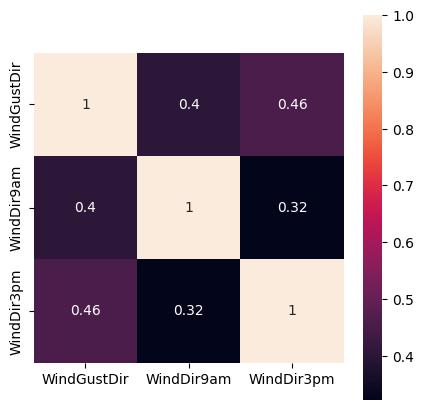

In [ ]:
### Matriz de correlación entre las variables de dirección del viento

corr_matrix = df_sel[['WindGustDir', 'WindDir9am', 'WindDir3pm']].corr(method='pearson')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(corr_matrix, square=True,ax=ax,annot=True)

Las direcciones del viento y de ráfagas no tienen una fuerte correlación entre sí.

Mantendremos las tres variables.

# Verificación de datos de lluvia faltantes

Intentaremos completar los datos faltantes de las variables objetivo utilizando el resto de las variables y las observaciones próximas como contexto.

In [ ]:
### Valores de 'RainfallTomorrow' para días donde 'RainTomorrow' es 0

df_sel[df_sel['RainTomorrow']==0][['RainTomorrow','RainfallTomorrow']].max()

RainTomorrow        0.0
RainfallTomorrow    1.0
dtype: float64

In [ ]:
### Valores de 'RainfallTomorrow' para días donde 'RainTomorrow' es 1

df_sel[df_sel['RainTomorrow']==1][['RainTomorrow','RainfallTomorrow']].min()

RainTomorrow        1.0
RainfallTomorrow    1.2
dtype: float64

Las variables de mayor interés son *RainTomorrow* y *RainfallTomorrow*.

Observamos que estas variables están relacionadas:

* Si *RainfallTomorrow* <= 1.0mm --> *RainTomorrow* = False

* Si *RainfallTomorrow* >= 1.2mm --> *RainTomorrow* = True

Verificamos si los valores faltantes de estas variables corresponden a los mismos registros.

Si no es así, podríamos completar algunos datos utilizando la regla anterior.

In [ ]:
### Verificamos si los registros donde faltan datos en RainTomorrow y RainfallTomorrow son los mismos

result = 'mismos registros'

for i in df_sel[df_sel['RainTomorrow'].isna()].index:
  if not(np.isnan(df_sel.loc[i]['RainfallTomorrow'])):
    result = 'registros distintos'

print(result)



mismos registros


RESULTADO: Al tratarse de los mismos registros no es posible completar datos faltantes.

---

Podemos hacer una búsqueda similar entre las variables *RainTomorrow* y *RainToday*.

Al contar con registros diarios en nuestro dataset, el valor de *RainTomorrow* de un registro se corresponde con el de *RainToday* del registro siguiente.

Verificamos si los datos faltantes pueden completarse usando los valores de los registros siguientes.



In [ ]:
### Verifico si los registros donde faltan datos en RainTomorrow y RainToday corresponden al mismo día

result = 'mismos registros'

for i in df_sel[df_sel['RainTomorrow'].isna()].index:
  if not(np.isnan(df_sel.loc[i+1]['RainToday'])):
    result = 'registros distintos'

print(result)


mismos registros


RESULTADO: La información falta en ambos registros, no es posible completar datos faltantes.

---

Como no es posible completar los registros donde faltan datos de lluvia, estos no se tendrán en cuenta para el análisis.

In [ ]:
### Se eliminan registros

df_sel.dropna(subset=['RainTomorrow','RainToday'], inplace=True)

In [ ]:
### Cantidad de valores faltantes

df_sel.isna().sum()

Date                   0
Location               0
MinTemp                8
MaxTemp                5
Rainfall               0
Evaporation         1681
Sunshine            1931
WindGustDir         1436
WindGustSpeed       1434
WindDir9am           672
WindDir3pm           288
WindSpeed9am         260
WindSpeed3pm         249
Humidity9am           86
Humidity3pm           43
Pressure9am          252
Pressure3pm          244
Cloud9am            1900
Cloud3pm            2136
Temp9am               22
Temp3pm               14
RainToday              0
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

Si bien queda resuelto el faltante de datos de las variables objetivo, también será necesario tratar los valores faltantes del resto de las características.

Para evitar data leakage, realizaremos las imputaciones sólo en el conjunto de entrenamiento luego de realizar el split del dataset.

# Comprobación del balance del dataset

Verificamos si contamos con un dataset balanceado para el análisis deseado.

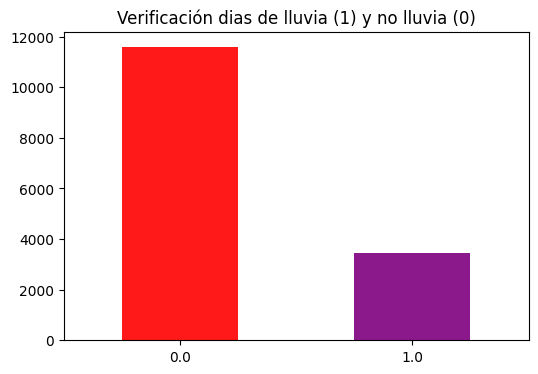

Dias sin lluvia: 11593
Dias con lluvia: 3443


In [ ]:
fig = plt.figure(figsize = (6,4))
df_sel.RainTomorrow.value_counts().plot(kind='bar', color= ['red','purple'], alpha = 0.9, rot=0)
plt.title('Verificación dias de lluvia (1) y no lluvia (0)')
plt.show()
print(f'Dias sin lluvia: {df_sel["RainTomorrow"][df_sel["RainTomorrow"]==0].count()}')
print(f'Dias con lluvia: {df_sel["RainTomorrow"][df_sel["RainTomorrow"]==1].count()}')

RESULTADO: Considerando los datos de *RainTomorrow* el dataset se encuentra considerablemente desbalanceado.

# Verificación de outliers

Para el análisis de outliers dividiremos el dataset en dos partes según la variable *RainTomorrow*.

Se utilizarán gráficos de cajas para comparar el comportamiento de este atributo para los dos valores y examinaremos la media y los valores máximos y mínimos.

In [ ]:
### Columnas

df_sel.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [ ]:
### Variables a analizar

labels=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainfallTomorrow']

In [ ]:
### División del dataset según 'RainTomorrow'

data0 = df_sel[labels][df_sel['RainTomorrow']==0]
data1 = df_sel[labels][df_sel['RainTomorrow']==1]

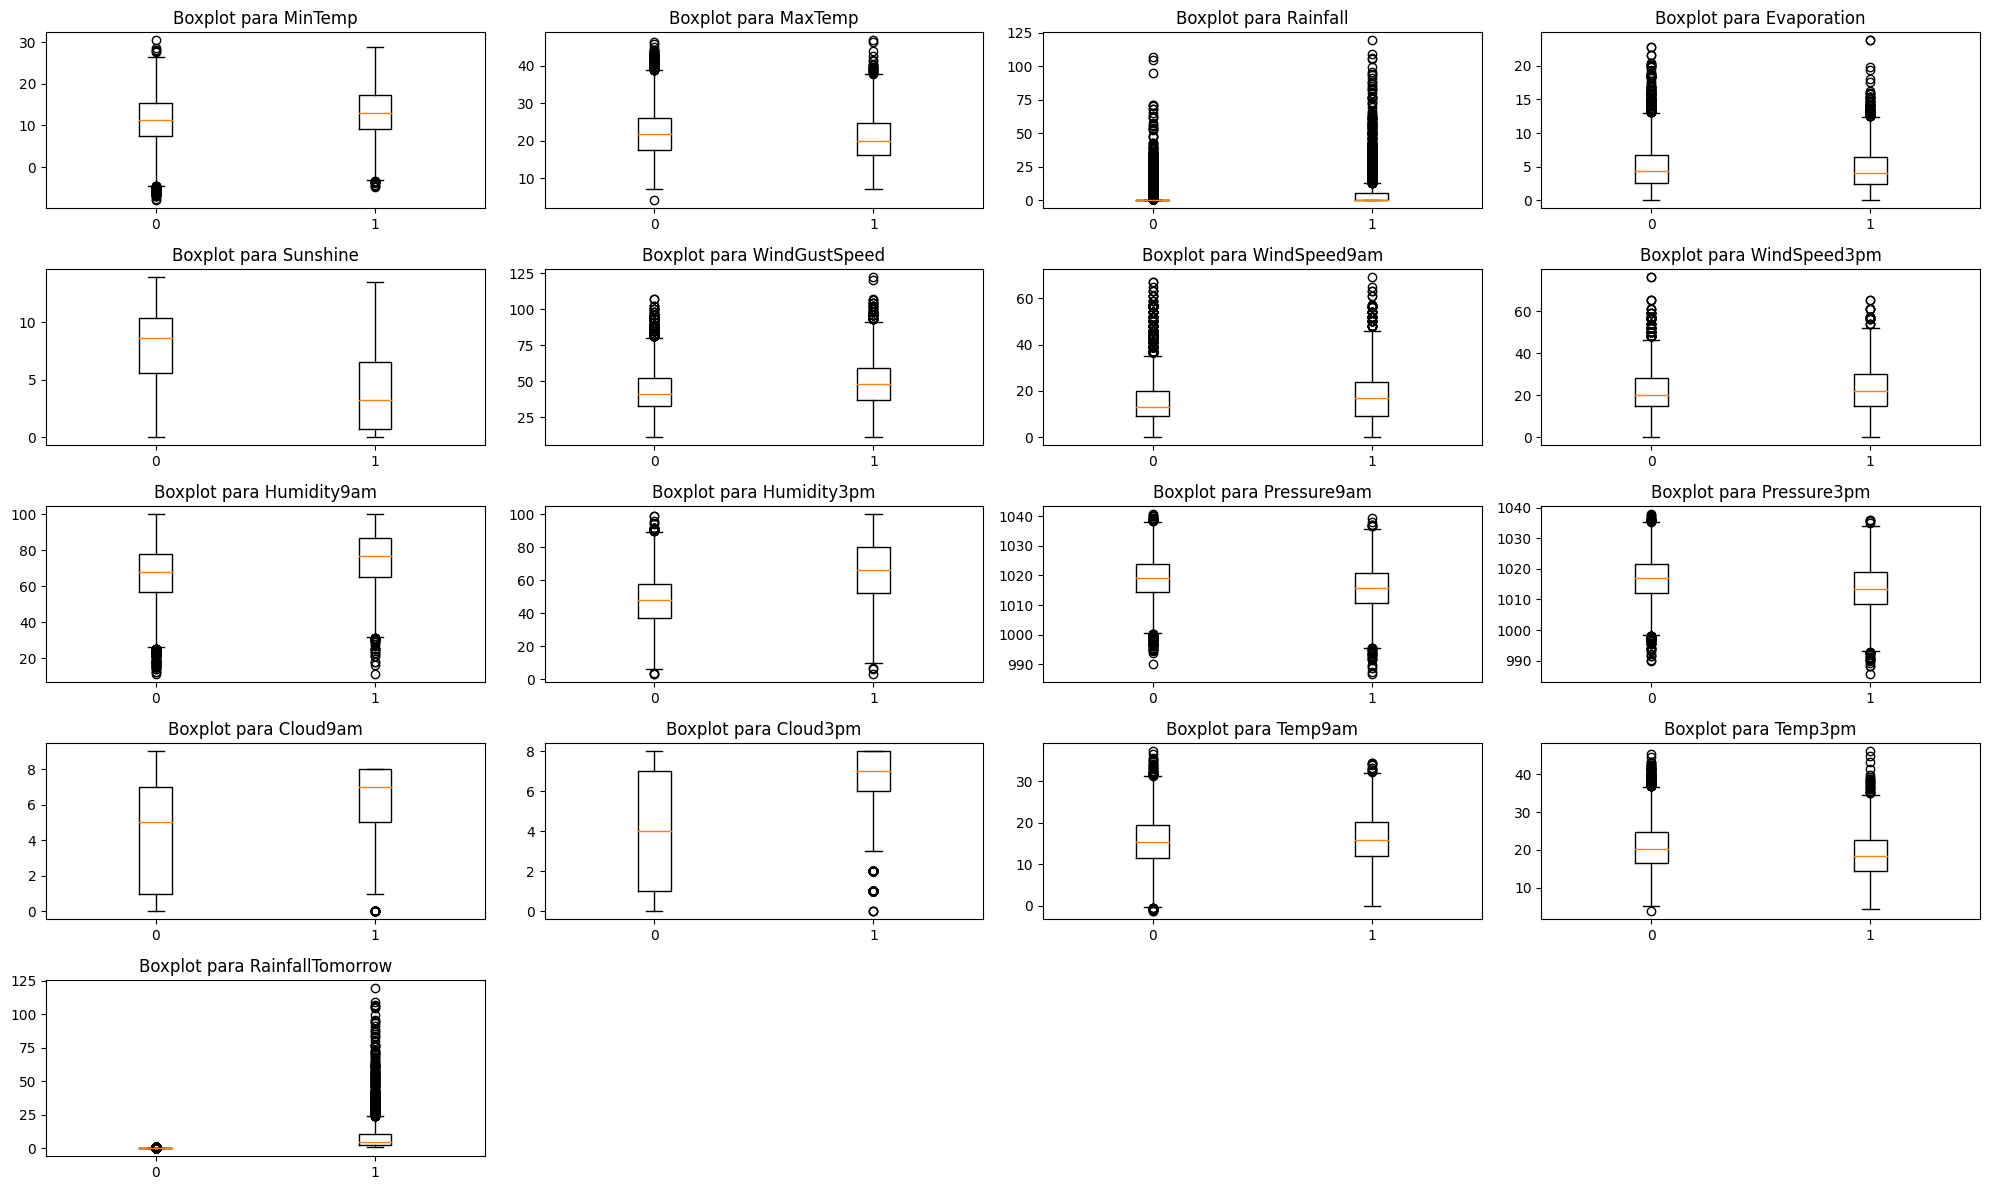

In [ ]:
### Boxplot para 'RainTomorrow' // 0 --> No llueve // 1 --> Llueve

num_etiquetas = len(labels)
num_columnas = 4
num_filas = (num_etiquetas + num_columnas - 1) // num_columnas # Número de filas necesario para acomodar todos los subplots

fig, axes = plt.subplots(num_filas, num_columnas, figsize=(20, 12))

for i, col in enumerate(labels):
    fila = i // num_columnas # Ubicación de fila y columna en la matriz de subplots, en función del índice
    columna = i % num_columnas

    ax = axes[fila, columna] # Subplot actual
    ax.boxplot([data0[col].dropna(), data1[col].dropna()], labels=['0', '1'])
    ax.set_title(f'Boxplot para {col}')

# Eliminamos subplots vacíos
for i in range(num_etiquetas, num_filas * num_columnas):
    fig.delaxes(axes[i // num_columnas, i % num_columnas])

plt.tight_layout()
plt.show()

Observando los boxplots, se pueden visualizar que en la mayoría de casos, los atributos se comportan por igual tanto para cuando llueve al día siguiente, como cuando no. Pero en otros casos, como por ejemplo 'Humidity3pm' o 'Cloud9am' y 'Cloud3pm', a valores más altos de estos atributos, estamos en presencia de lluvia al día siguiente. En el caso de 'Sunshine' ocurre al revés, en valores más altos de esta característica notamos que no llueve al día siguiente.

Se pueden ver datos atípicos, pero sólo con el boxplot no podemos determinar este comportamiento.

In [ ]:
### Valores de interés para describir compartamiento de características

df_sel.describe()

MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  15028.000000  15031.000000  15036.000000  13355.000000  13105.000000   
mean      11.612610     21.803739      2.299601      4.881041      6.907707   
std        5.886335      6.058224      7.404618      3.056038      3.837245   
min       -8.000000      4.100000      0.000000      0.000000      0.000000   
25%        7.900000     17.200000      0.000000      2.600000      3.800000   
50%       11.600000     21.300000      0.000000      4.200000      7.600000   
75%       15.900000     25.800000      0.800000      6.600000     10.000000   
max       30.500000     46.800000    119.400000     23.800000     13.900000   

        WindGustDir  WindGustSpeed    WindDir9am    WindDir3pm  WindSpeed9am  \
count  13600.000000   13602.000000  14364.000000  14748.000000  14776.000000   
mean       7.494191      44.290619      7.562239      8.038988     16.443760   
std        4.551052      14.948251      4.469110      4.583090     10.264783   
min        1.000000      11.000000      1.000000      1.000000      0.000000   
25%        3.000000      33.000000      3.000000      4.000000      9.000000   
50%        7.000000      43.000000      8.000000      8.000000     15.000000   
75%       11.000000      54.000000     11.000000     12.000000     22.000000   
max       16.000000     122.000000     16.000000     16.000000     69.000000   

       ...   Humidity3pm   Pressure9am   Pressure3pm      Cloud9am  \
count  ...  14993.000000  14784.000000  14792.000000  13136.000000   
mean   ...     51.239645   1018.338400   1016.077778      4.737972   
std    ...     17.757028      7.400836      7.265255      2.731119   
min    ...      3.000000    986.700000    985.500000      0.000000   
25%    ...     39.000000   1013.400000   1011.200000      2.000000   
50%    ...     51.000000   1018.500000   1016.300000      6.000000   
75%    ...     62.000000   1023.300000   1021.000000      7.000000   
max    ...    100.000000   1040.600000   1037.900000      9.000000   

           Cloud3pm       Temp9am       Temp3pm     RainToday  RainTomorrow  \
count  12900.000000  15014.000000  15022.000000  15036.000000  15036.000000   
mean       4.735349     15.588770     20.277899      0.232442      0.228984   
std        2.593540      5.572921      5.861972      0.422403      0.420193   
min        0.000000     -1.300000      3.700000      0.000000      0.000000   
25%        2.000000     11.600000     16.000000      0.000000      0.000000   
50%        6.000000     15.500000     19.800000      0.000000      0.000000   
75%        7.000000     19.600000     24.200000      0.000000      0.000000   
max        8.000000     37.200000     46.100000      1.000000      1.000000   

       RainfallTomorrow  
count      15036.000000  
mean           2.250213  
std            7.318972  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.800000  
max          119.400000  

[8 rows x 22 columns]

Teniendo en cuenta los valores máximos y mínimos para las variables de interés, no consideramos que los outliers representen valores que alteren el resultado del análisis. Por lo tanto, no le daremos un trato particular.

# Split del dataset

Realizamos la siguiente división:
* 85% -> Train
* 15% -> Test

In [ ]:
### División de los datos en train y test

X = df_sel.drop(columns=['RainfallTomorrow','RainTomorrow','Date', 'Location'])
y = df_sel['RainfallTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), test_size=0.15, random_state = 12)

Al considerarse todas las ubicaciones parte de una misma zona de análisis, se elimina la variable *Location* del conjunto de datos.



In [ ]:
### Chequeo del tamaño de X_train y X_test
X_train.shape, X_test.shape

((12780, 20), (2256, 20))

# Ingeniería de características

### Funciones a utilizar

In [ ]:
def imputar_moda(train, test, columnas):
  '''Función que imputa por la moda al conjunto de train y de test en las columnas necesarias.'''

  imputer= SimpleImputer(strategy='most_frequent')
  train[columnas] = imputer.fit_transform(train[columnas])
  test[columnas] = imputer.transform(test[columnas])

  return train, test

def imputar_media(train, test):
  '''Función que imputa por la media al conjunto de train y test.'''

  imputer= SimpleImputer(strategy='mean')
  arr_train = imputer.fit_transform(train)
  arr_test = imputer.transform(test)

  df_train = pd.DataFrame(arr_train, columns=train.columns)
  df_test = pd.DataFrame(arr_test, columns=train.columns)

  return df_train, df_test


def escalar_datos(df_train, df_test):
  '''Función que escala los datos utilizando StandardScaler()'''

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(df_train)
  X_test_scaled = scaler.transform(df_test)

  return X_train_scaled, X_test_scaled

## Tratamiento de últimos valores faltantes



In [ ]:
### Cantidad de valores faltantes

X_train.isna().sum()

MinTemp             7
MaxTemp             3
Rainfall            0
Evaporation      1422
Sunshine         1638
WindGustDir      1226
WindGustSpeed    1224
WindDir9am        575
WindDir3pm        246
WindSpeed9am      219
WindSpeed3pm      212
Humidity9am        74
Humidity3pm        36
Pressure9am       218
Pressure3pm       211
Cloud9am         1609
Cloud3pm         1818
Temp9am            18
Temp3pm            12
RainToday           0
dtype: int64

Para los valores nulos del viento optaremos por completar con la moda del conjunto, ya que estos atributos originalmente eran categóricos.

In [ ]:
col = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
X_train, X_test = imputar_moda(X_train, X_test, col)

In [ ]:
X_train[col].isna().sum()

WindGustDir    0
WindDir9am     0
WindDir3pm     0
dtype: int64

Para los numéricos, optamos imputar por la media.

In [ ]:
X_train.isna().sum()

MinTemp             7
MaxTemp             3
Rainfall            0
Evaporation      1422
Sunshine         1638
WindGustDir         0
WindGustSpeed    1224
WindDir9am          0
WindDir3pm          0
WindSpeed9am      219
WindSpeed3pm      212
Humidity9am        74
Humidity3pm        36
Pressure9am       218
Pressure3pm       211
Cloud9am         1609
Cloud3pm         1818
Temp9am            18
Temp3pm            12
RainToday           0
dtype: int64

In [ ]:
X_train_df, X_test_df = imputar_media(X_train, X_test)

In [ ]:
X_test_df.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
dtype: int64

##Selección de características

Utilizando los coeficientes de la matriz de correlacion determinaremos qué características son relevantes para aplicar los modelos de predicción.

De esta manera conseguimos disminuir los costos computacionales en el entrenamiento y test de los modelos, y también conseguimos mejorar la interpretabilidad de los datos.

<Axes: >

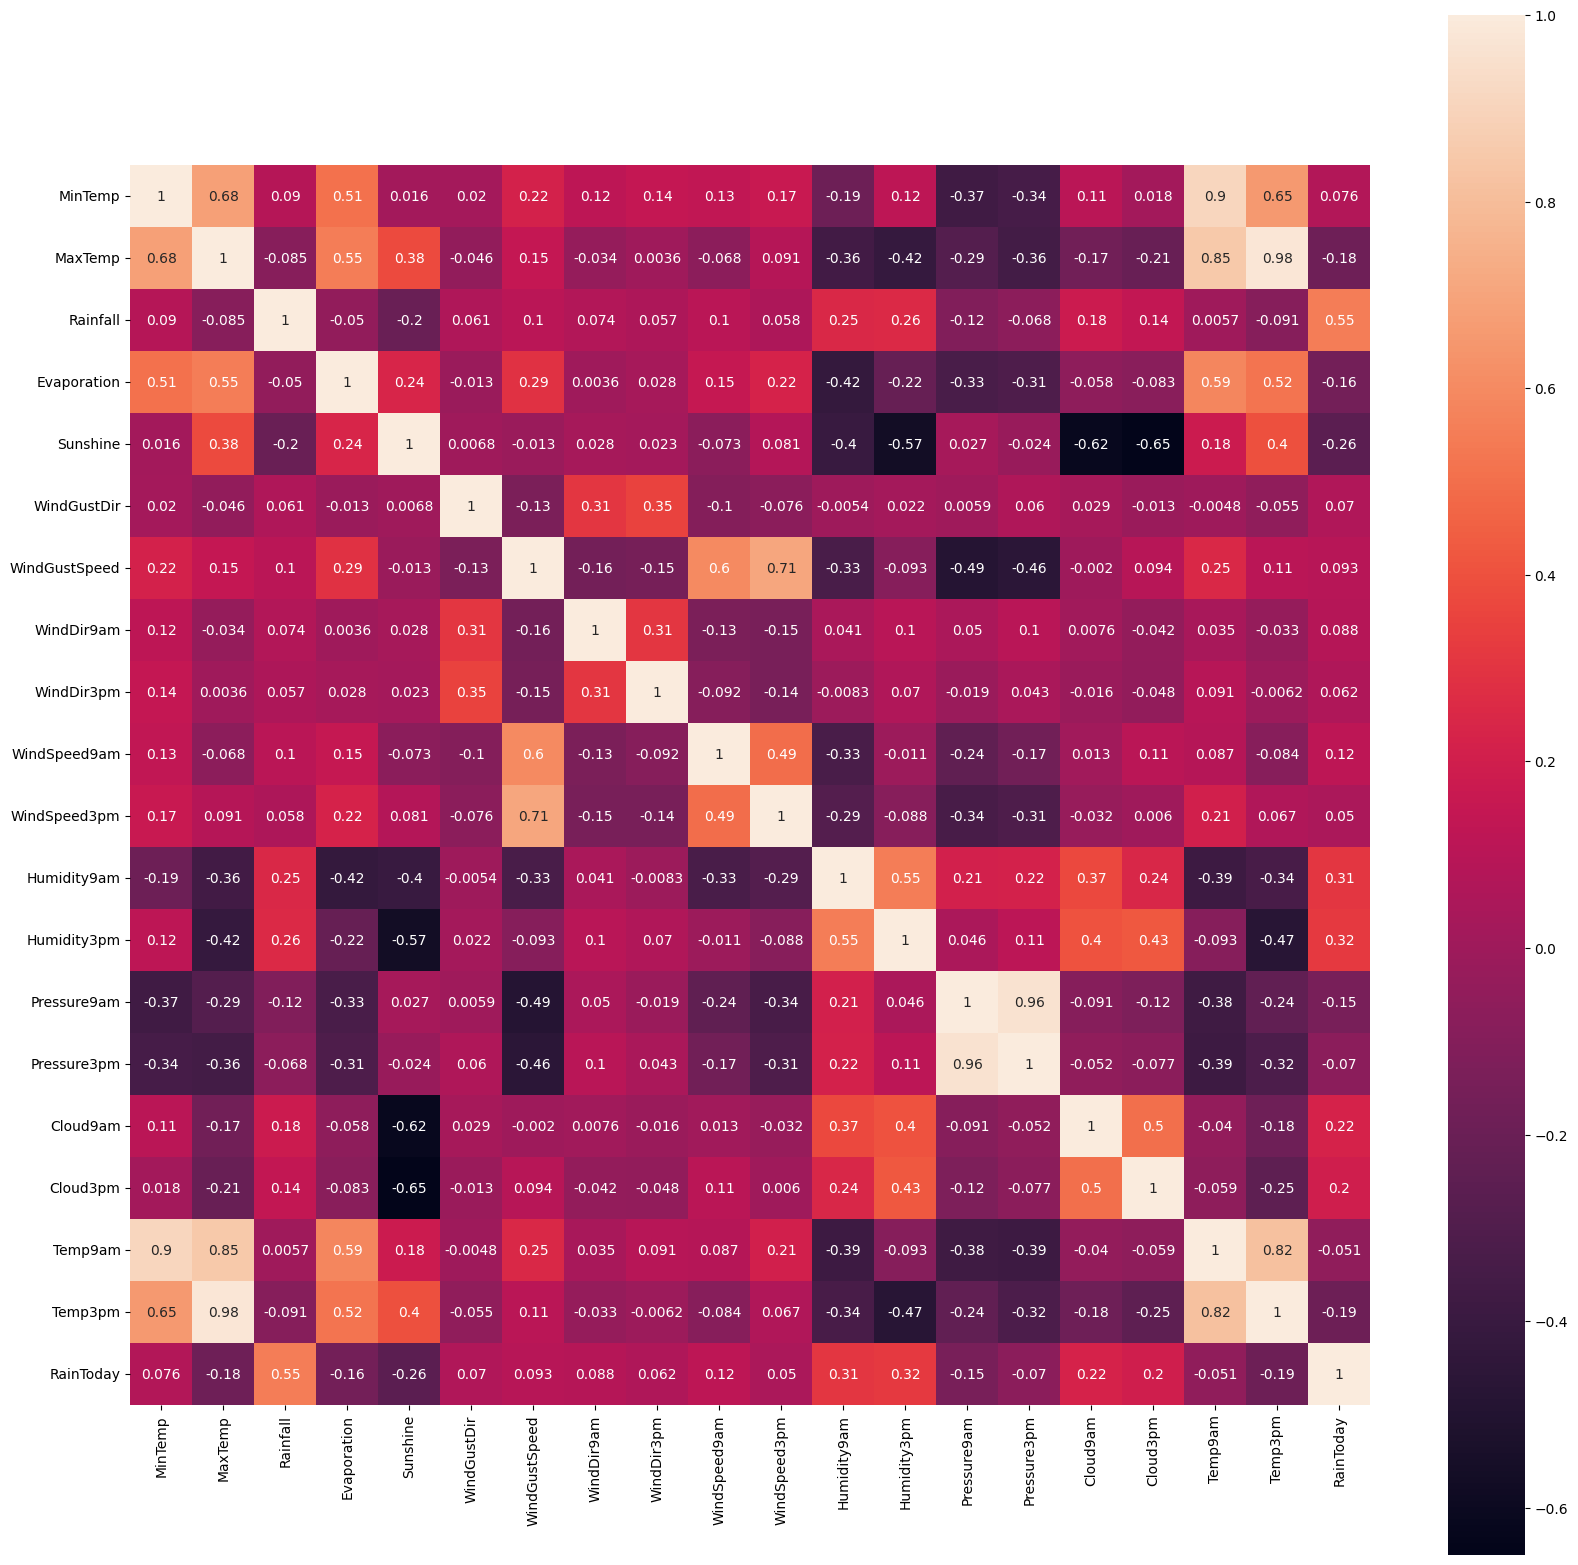

In [ ]:
### Matriz de correlación

corr_matrix = X_train_df.corr(method='pearson')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

sns.heatmap(corr_matrix, square=True,ax=ax,annot=True)

* En el heatmap anterior se puede observar una fuerte correlación entre los valores de Presión 9am con los de 3am. Para el análisis sería conveniente quedarnos sólo con *Pressure3pm*.

* Lo mismo sucede para los valores de Temperatura 9am con Mínima y 3pm con Máxima. Consideramos que es válido trabajar sólo con *MinTemp* y *MaxTemp*.


In [ ]:
### Eliminamos las características mencionadas

X_train_df.drop(columns = ['Temp9am','Temp3pm','Pressure9am'], inplace = True)

X_test_df.drop(columns = ['Temp9am','Temp3pm','Pressure9am'], inplace = True)

<Axes: >

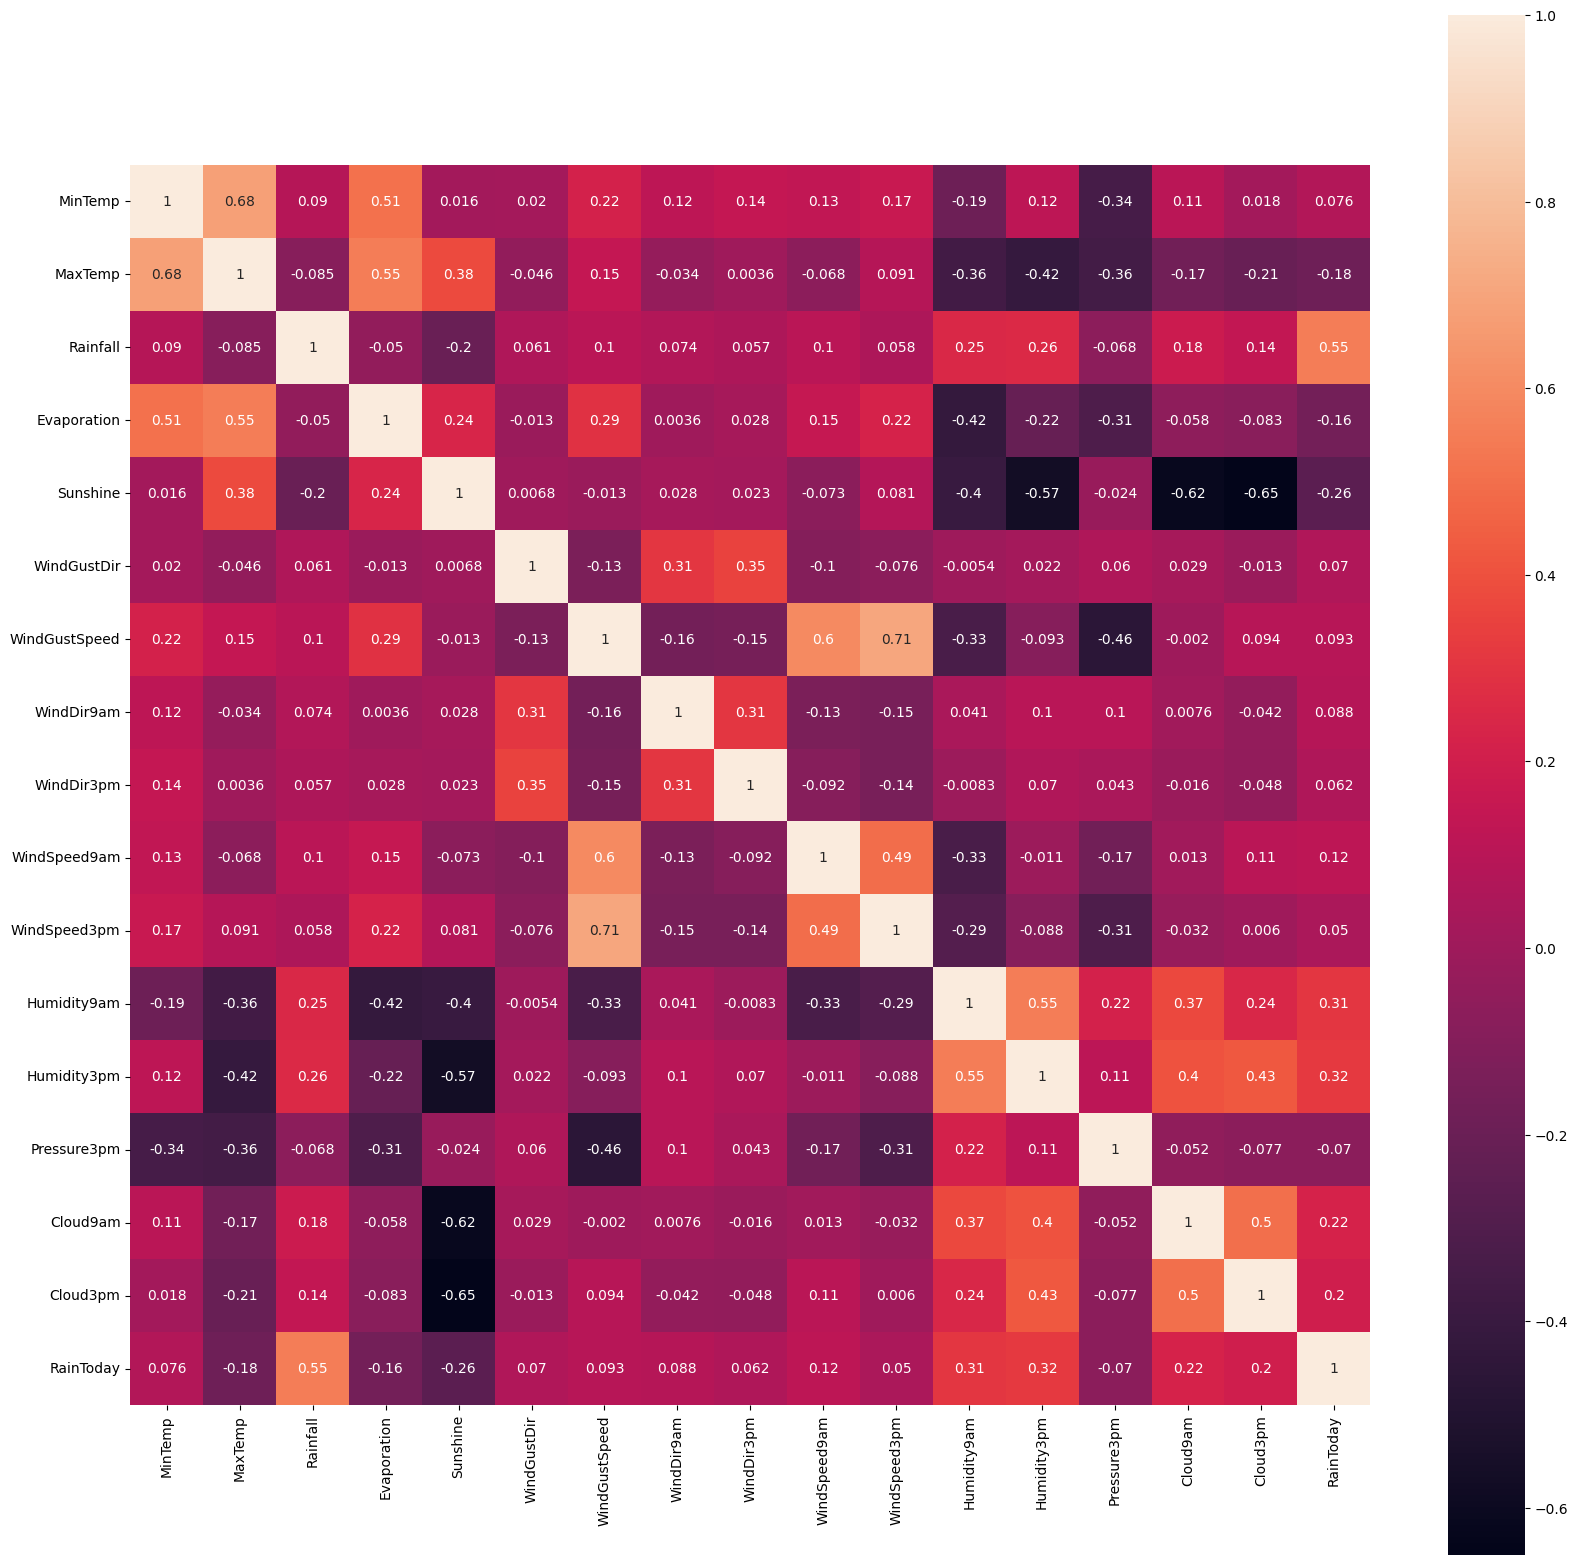

In [ ]:
### Matriz de correlación reducida

corr_matrix = X_train_df.corr(method='pearson')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

sns.heatmap(corr_matrix, square=True,ax=ax,annot=True)

In [ ]:
X_train_df.head()

MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine  WindGustDir  \
0     19.7     26.2       0.4     2.600000  10.900000         15.0   
1     12.6     25.1       0.2     4.898151   6.908831         12.0   
2     19.0     32.2       0.0    10.600000  12.400000         11.0   
3     10.3     20.9       0.0     5.400000  10.400000         11.0   
4     19.5     33.9       0.0    10.200000  11.300000          1.0   

   WindGustSpeed  WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  \
0           33.0        14.0        14.0          15.0          19.0   
1           30.0        15.0         3.0           7.0          19.0   
2           61.0         5.0        12.0          17.0          37.0   
3           39.0        11.0         3.0          22.0           7.0   
4           65.0         1.0         1.0          30.0          39.0   

   Humidity9am  Humidity3pm  Pressure3pm  Cloud9am  Cloud3pm  RainToday  
0         75.0         62.0       1012.5  4.739862  4.739007        0.0  
1         92.0         41.0       1015.8  8.000000  1.000000        0.0  
2         22.0         15.0        998.6  0.000000  3.000000        0.0  
3         54.0         32.0       1016.8  1.000000  3.000000        0.0  
4         48.0         29.0       1012.1  7.000000  7.000000        0.0

In [ ]:
columnas = X_train_df.columns
columnas

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')

## Escalado

Es fundamental para un correcto análisis de las características que los valores estén estandarizados. En este caso estamos trabajando con magnitudes diferentes (presión [hpa], temperatura [°C], humedad [%], lluvia [mm]) y cada una presenta una varianza particular.

Estandarizando los datos buscamos que la varianza sea igual en todas las características.

Realizaremos estandarización utilizando StandardScaler, que por cada muestra resta la media y divide por el desvío std.

In [ ]:
X_train_scaled, X_test_scaled = escalar_datos(X_train_df, X_test_df)

In [ ]:
X_train_df

MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine  WindGustDir  \
0         19.7     26.2       0.4     2.600000  10.900000         15.0   
1         12.6     25.1       0.2     4.898151   6.908831         12.0   
2         19.0     32.2       0.0    10.600000  12.400000         11.0   
3         10.3     20.9       0.0     5.400000  10.400000         11.0   
4         19.5     33.9       0.0    10.200000  11.300000          1.0   
...        ...      ...       ...          ...        ...          ...   
12775     10.1     18.0      14.6     5.200000   1.300000          1.0   
12776     11.3     20.0       4.4     2.200000   5.800000         11.0   
12777     10.4     34.4       0.0     4.898151   6.908831          1.0   
12778     18.1     25.4       0.0     5.000000   9.500000         16.0   
12779     14.4     25.1       0.4     4.200000  12.200000          7.0   

       WindGustSpeed  WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  \
0               33.0        14.0        14.0          15.0          19.0   
1               30.0        15.0         3.0           7.0          19.0   
2               61.0         5.0        12.0          17.0          37.0   
3               39.0        11.0         3.0          22.0           7.0   
4               65.0         1.0         1.0          30.0          39.0   
...              ...         ...         ...           ...           ...   
12775           76.0         1.0         1.0          31.0          50.0   
12776           26.0        11.0        10.0          19.0           9.0   
12777           44.0        14.0         5.0           4.0          20.0   
12778           39.0        16.0        16.0          24.0          22.0   
12779           54.0         7.0         7.0          15.0          33.0   

       Humidity9am  Humidity3pm  Pressure3pm  Cloud9am  Cloud3pm  RainToday  
0             75.0         62.0       1012.5  4.739862  4.739007        0.0  
1             92.0         41.0       1015.8  8.000000  1.000000        0.0  
2             22.0         15.0        998.6  0.000000  3.000000        0.0  
3             54.0         32.0       1016.8  1.000000  3.000000        0.0  
4             48.0         29.0       1012.1  7.000000  7.000000        0.0  
...            ...          ...          ...       ...       ...        ...  
12775         93.0         89.0        985.5  8.000000  8.000000        1.0  
12776         88.0         60.0       1025.2  6.000000  1.000000        1.0  
12777         50.0         13.0       1008.6  4.739862  4.739007        0.0  
12778         53.0         55.0       1018.9  4.000000  2.000000        0.0  
12779         60.0         31.0       1021.0  1.000000  4.739007        0.0  

[12780 rows x 17 columns]

# Regresión

## Modelo base de regresión

Creamos un modelo base tomando el valor medio de "RainfallTomorrow" del dataset original.

In [ ]:
media = np.mean(y_train)

# Modelo base basado en la media
def modelo_base_media(df):
    return [media] * len(df)

predicciones_base_reg = modelo_base_media(X_test_scaled)

print("Predicciones del modelo base:")
print(predicciones_base_reg)

Predicciones del modelo base:
[2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536776212836, 2.2463536

In [ ]:
# Métricas modelo base regresión
rmse_ols = mean_squared_error(y_test, predicciones_base_reg, squared = False)
R2_base = metrics.r2_score(y_test, predicciones_base_reg)

print(f"El error (rmse) del modelo base es: {rmse_ols}")
print(f"El R2 del modelo base es: {R2_base}")

El error (rmse) del modelo base es: 7.451797023996958
El R2 del modelo base es: -1.1913839996768871e-05


El R2 del modelo base se puede considerar que es 0.

En el caso de un modelo que simplemente predice la media, no está capturando ninguna variabilidad en los datos, ya que está dando la misma predicción (la media) para todos los casos.

Cuando el modelo predice la media, la varianza no explicada es igual a la varianza total, lo que resulta en: R2=1−1=0.


## Regresión Lineal

In [ ]:
# Creación y entrenamiento del modelo

model_reg = LinearRegression()

In [ ]:
model_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
# Cantidad de features

model_reg.n_features_in_

17

In [ ]:
# Vista general de coeficientes

model_reg.coef_

array([[-0.94541638,  1.63497823,  1.36712452,  0.08277873, -1.23593352,
         0.16435623,  1.45869872,  0.2059135 ,  0.06954244, -0.05729303,
        -0.5458934 , -0.09088241,  2.5665902 , -0.24704396, -0.3316594 ,
         0.03733918, -0.0805082 ]])

In [ ]:
# Ordenada al origen

model_reg.intercept_

array([2.24635368])

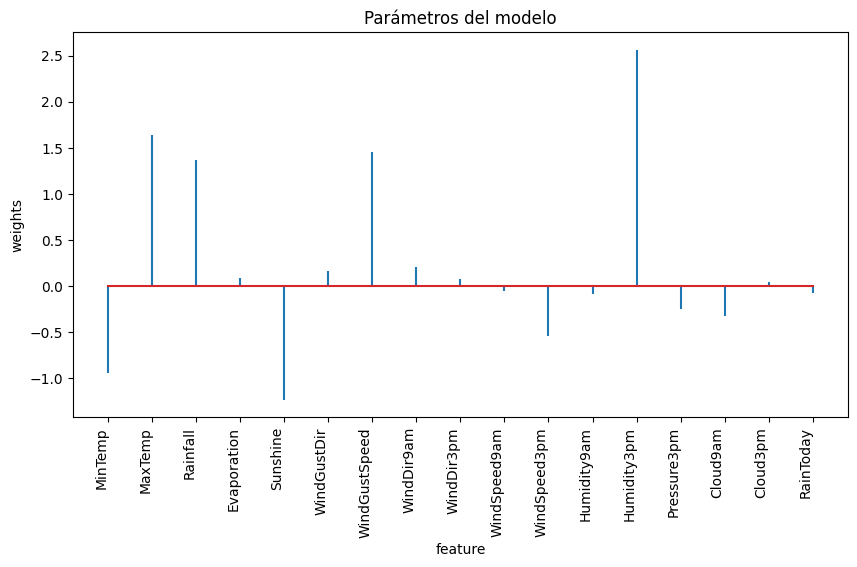

In [ ]:
# Coeficientes del modelo y su importancia

df_coeficientes = pd.DataFrame({'predictor': columnas, 'coef': model_reg.coef_.flatten()})

fig, ax = plt.subplots(figsize=(10, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo')
plt.show()

In [ ]:
df_coeficientes

predictor      coef
0         MinTemp -0.945416
1         MaxTemp  1.634978
2        Rainfall  1.367125
3     Evaporation  0.082779
4        Sunshine -1.235934
5     WindGustDir  0.164356
6   WindGustSpeed  1.458699
7      WindDir9am  0.205913
8      WindDir3pm  0.069542
9    WindSpeed9am -0.057293
10   WindSpeed3pm -0.545893
11    Humidity9am -0.090882
12    Humidity3pm  2.566590
13    Pressure3pm -0.247044
14       Cloud9am -0.331659
15       Cloud3pm  0.037339
16      RainToday -0.080508

In [ ]:
# Predicciones test

y_pred = model_reg.predict(X_test_scaled)
y_pred.shape, y_test.shape

((2256, 1), (2256, 1))

### Metricas

####Error de test y de train

In [ ]:
# Error de test del modelo. Usamos rmse para mantener la misma escala que la variable a predecir

rmse_ols = mean_squared_error(y_test, y_pred, squared = False)

print(f"El error (rmse) de test es: {rmse_ols.round(3)}")

El error (rmse) de test es: 6.49


In [ ]:
# Predicciones train

y_pred_train = model_reg.predict(X_train_scaled)
y_pred_train.shape, y_train.shape

((12780, 1), (12780, 1))

In [ ]:
# Error de train
rmse_ols_train = mean_squared_error(y_train, y_pred_train, squared = False)

print(f"El error (rmse) de train es: {rmse_ols_train.round(3)}")

El error (rmse) de train es: 6.439


#### R2 de train y de test

In [ ]:
# Test
R2 = metrics.r2_score(y_test, y_pred)
print(f'R2 del conjunto de test: {R2.round(3)}')

R2 del conjunto de test: 0.242


In [ ]:
# Train
R2_train = metrics.r2_score(y_train, y_pred_train)
print(f'R2 del conjunto de train: {R2_train.round(3)}')

R2 del conjunto de train: 0.221


In [ ]:
(y_test - y_pred).shape

(2256, 1)

Ambos métricas, tanto en train como en test, son similares. Puede deducirse que no estamos en presencia de overfitting.

#### Análisis de Residuos

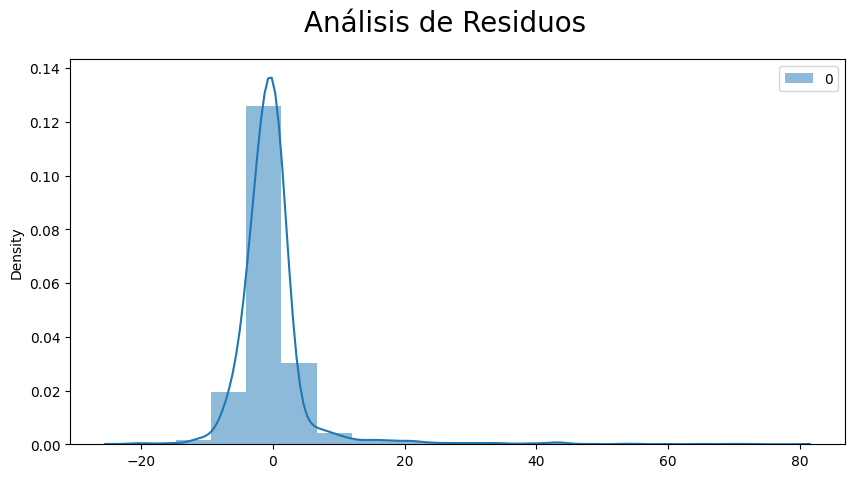

In [ ]:
fig = plt.figure(figsize=(10,5))

sns.histplot((y_test - y_pred), color="red", kde=True, stat="density", linewidth=0,bins=20)
fig.suptitle('Análisis de Residuos', fontsize = 20)
plt.show()

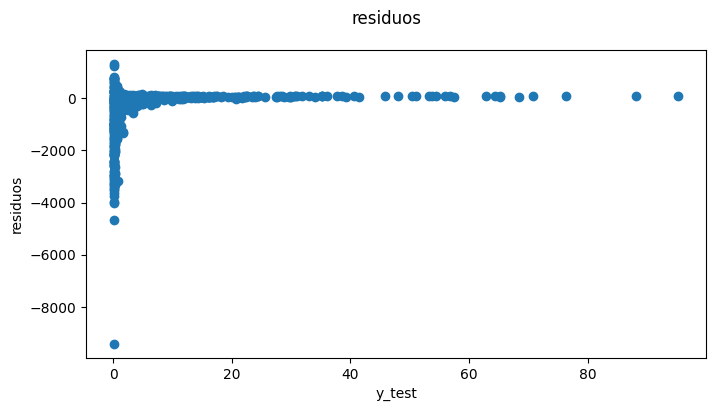

In [ ]:
fig = plt.figure(figsize=(8,4))
fig.suptitle('residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test,100*(y_test-y_pred)/y_test)
plt.show()

Los residuos representan la diferencia entre los valores observados y las predicciones del modelo. Observando ambas gráficas del análisis de residuos notamos que se distribuyen la mayoría de estos cerca del 0. De todos modos se hallan muchos otros puntos de observaciones lejos de este valor.

#### Validación cruzada

In [ ]:
# Aplicamos 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model_reg, X_train_scaled, y_train, scoring='r2', cv=kf)

# Imprimimos resultados
print('Cross-validation scores:{}'.format(scores))

# Calculamos la media de los resultados
print('Average cross-validation score: {:.4f}'.format(scores.mean()))


Cross-validation scores:[0.21872576 0.22896068 0.21373369 0.21001331 0.21442704]
Average cross-validation score: 0.2172


Nuestro r2 score del modelo de regresión original resultó ser 0.221. La media del r2 score de la Validación Cruzada es 0.217.

Podemos concluir que la validación cruzada no dio resultados en la mejora del desempeño.

En el caso de este modelo, no realizamos optimización de hiperparámetros ya que no aplicamos parámetros en la instancia de creación del modelo.

###Explicabilidad SHAP

In [ ]:
feature_names = X_train_df.columns

In [ ]:
# Creamos el objeto explainer SHAP
explainer = shap.LinearExplainer(model_reg, X_train_scaled, feature_names=feature_names)

In [ ]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled)

In [ ]:
explainer.expected_value

2.194718998532898

####Interpretabilidad local

Observamos cómo se comporta un dato del conjunto de test.

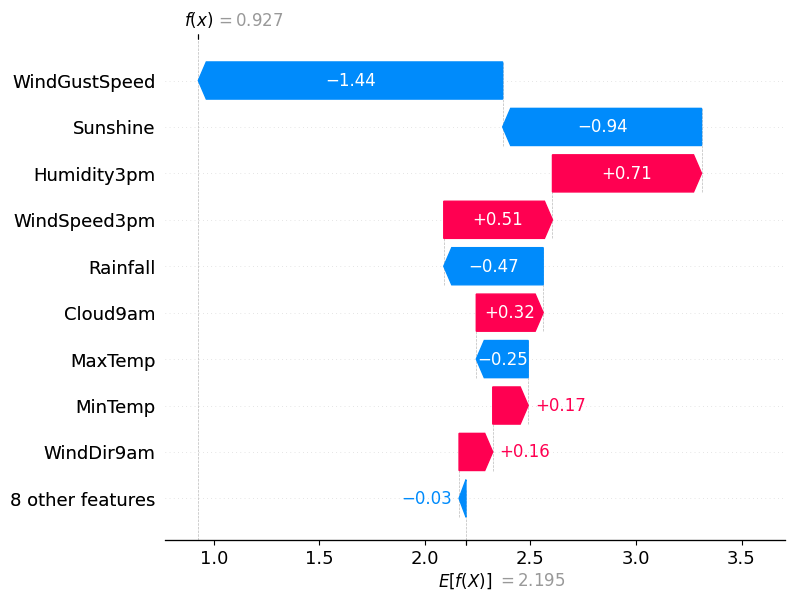

In [ ]:
# Gráfico cascada
index=0
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.waterfall(explanation)

En el gráfico de cascada, vemos cómo impacta cada variable explicativa en una predicción en particular.

Por ejemplo, notamos que 'WindGustSpeed' es la variable que más está restando a la hora de predecir la cantidad de lluvia para mañana. Luego. 'Sunshine' también resta, pero en menor medida.

Por otro lado, la variable 'Humidity3pm' es la que nos está sumando más a la hora de predecir, luego le sigue 'WindSpeed3pm'


El valor base es igual a la media de la variable 'RainfallTomorrow'

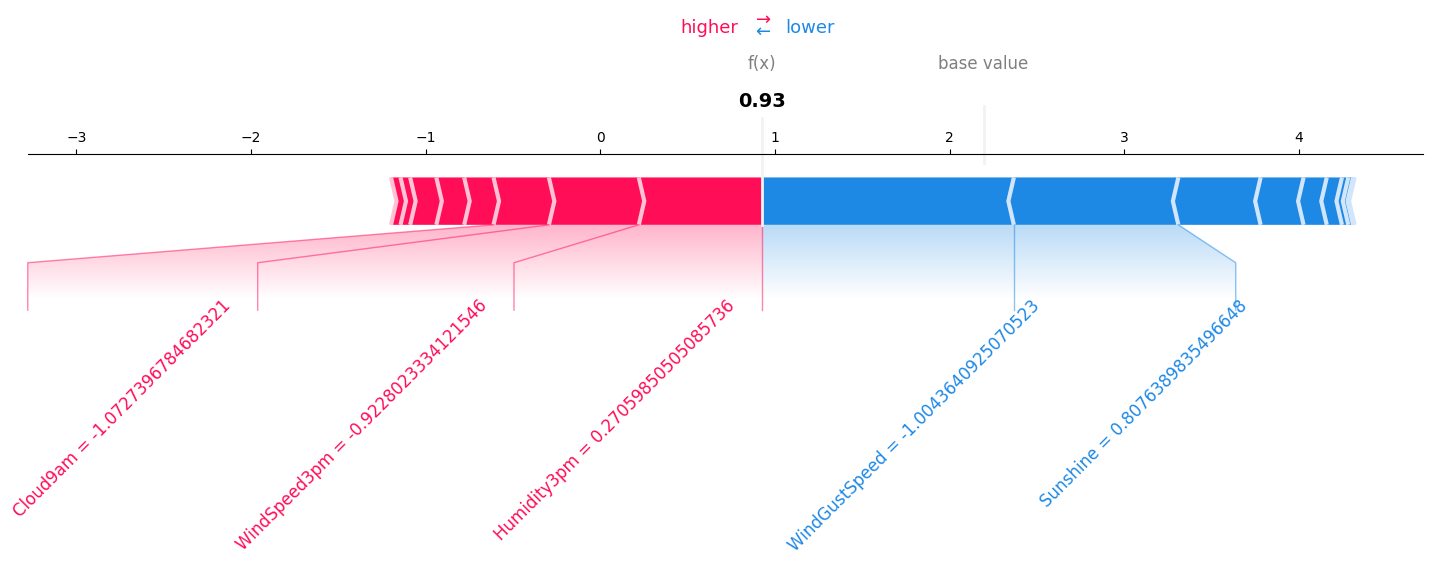

In [ ]:
# Gráfico de fuerza
index=0
shap.force_plot(explainer.expected_value, shap_values[index], X_test_scaled[index], feature_names=feature_names, matplotlib=True, figsize=(18, 4), \
                text_rotation=45)

En el gráfico de fuerza se puede ver, para una predicción de 'RainfallTomorrow' de 0.93, las variables explicativas que más peso tienen y cuáles son aquellas que están sumando y restando cantidad de lluvia.

Se puede corroborar con el gráfico de cascada que la variable 'WindGustSpeed' es la que más peso tiene y cómo esta restando a la hora de predecir, y que 'Humidity3pm' es aquella que más peso tiene a la hora de sumar.



#### Interpretabilidad global

Vemos cómo impactan todas las variables explicativas sobre todo el conjunto de test.

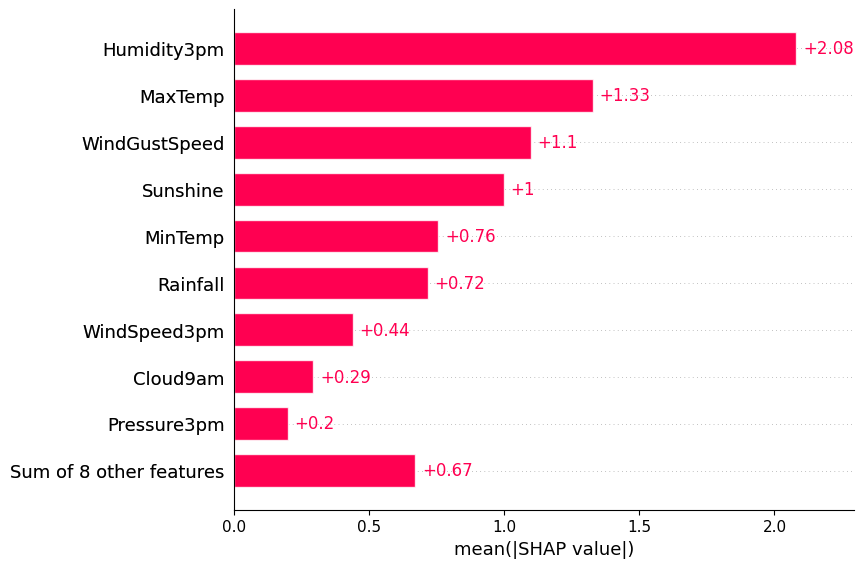

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_scaled)
shap.plots.bar(explanation)

Podemos notar cómo impacta la salida en función de todas las variables explicativas, en promedio.

Vemos que 'Humidity3pm' es la variable más importante a la hora de explicar globalmente, en promedio, la predicción. Le sigue 'MaxTemp' y luego 'WindGustSpeed'.

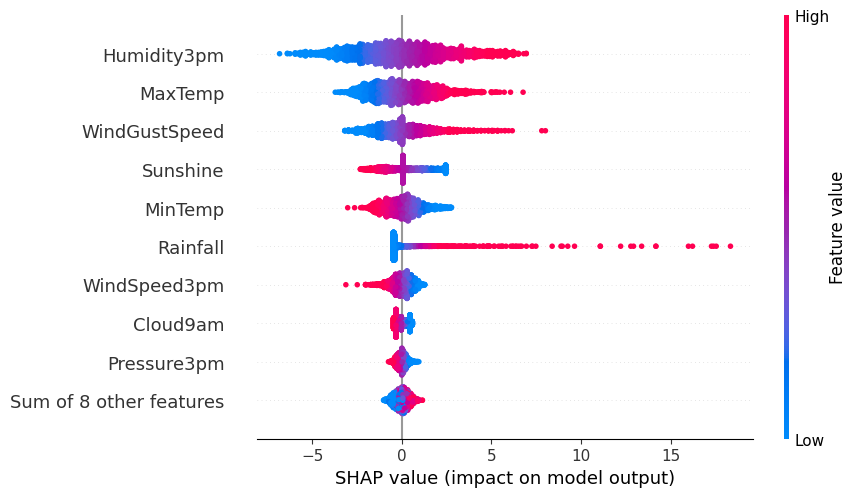

In [ ]:
# Gráfica enjambre de abejas
shap.plots.beeswarm(explanation)

Vemos el impacto que ocurre en la predicción para valores altos y bajos de las variables explicativas, y cómo están distribuidos los puntos para cada una.

Por ejemplo, se puede observar que, mientras más baja es 'Humidity3pm', menor cantidad de lluvia se va a tener para el día siguiente, y mientras más alta es esta variable, mayor cantidad de lluvia se tendrá.

## Gradiente descendiente

### Funciones

In [ ]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W, test_mse

In [ ]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

In [ ]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

### Aplicación

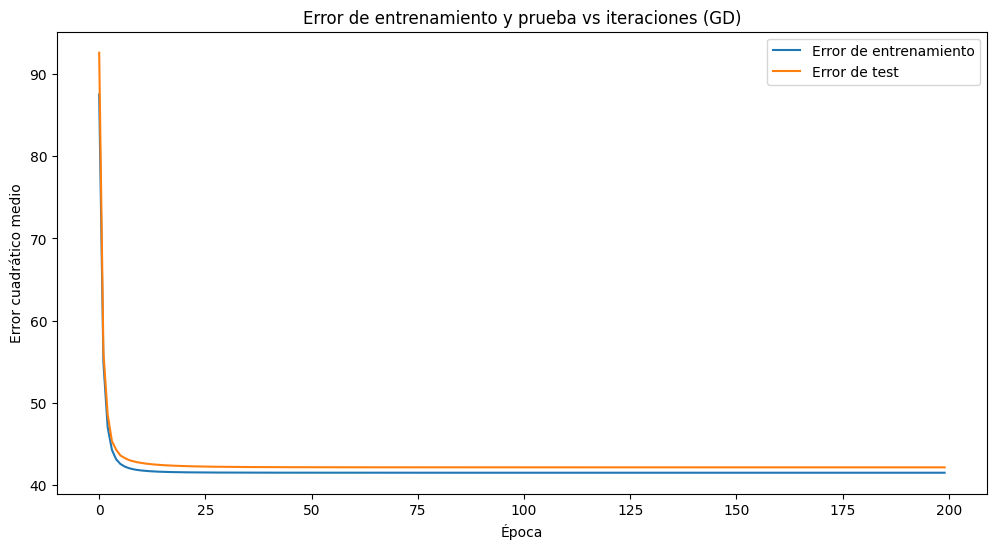

In [ ]:
# Gradiente descendiente

GD_coef, GD_test_err = gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=200, lr=0.2)

Utilizando como hiperparámetros: epochs=200 y lr=0.2, notamos que la función converge cuando el error cuadrático medio tiene un valor cercano a 42.

In [ ]:
GD_coef

array([[ 2.24635368],
       [-0.94526286],
       [ 1.634813  ],
       [ 1.36713202],
       [ 0.08278171],
       [-1.23591318],
       [ 0.16435612],
       [ 1.45871476],
       [ 0.2058993 ],
       [ 0.06953034],
       [-0.05732223],
       [-0.54590797],
       [-0.09084716],
       [ 2.56648564],
       [-0.24704443],
       [-0.33167329],
       [ 0.03736387],
       [-0.08052527]])

In [ ]:
GD_test_err

42.116395013693605

Se obtiene un error bastante alto en comparación a la regresión lineal.

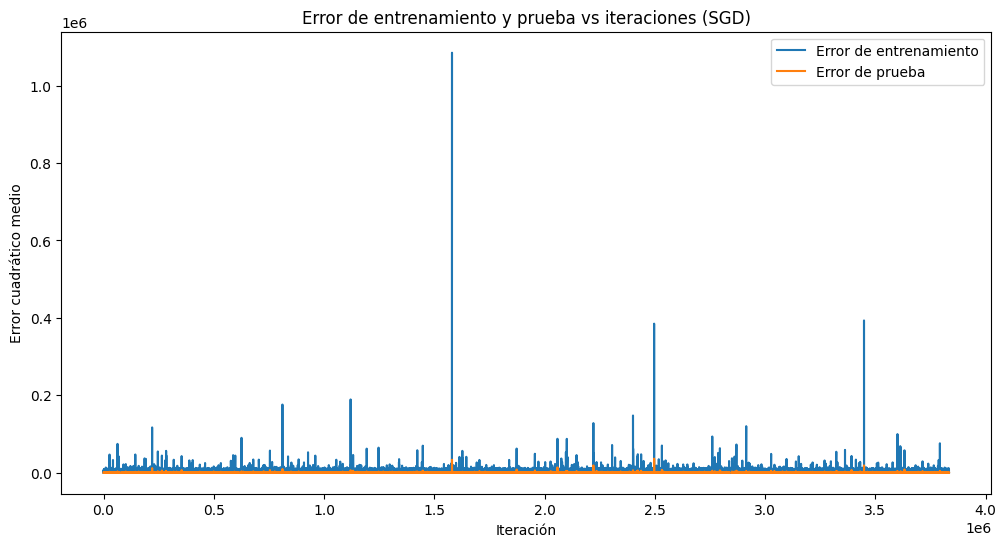

In [ ]:
# Gradiente descendiente estocástico

SGD_coef = stochastic_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=300, lr=0.01)

Luego de numerosos intentos y cambios en los hiperparámetros, no pudimos llegar a una convergencia en el modelo. Sospechamos que esto se puede deber a que en este caso, la actualización de los parámetros es más frecuente y se basa en información menos precisa ya que utiliza solo una muestra de los datos en lugar de todo el conjunto y puede estar tomando ruido.

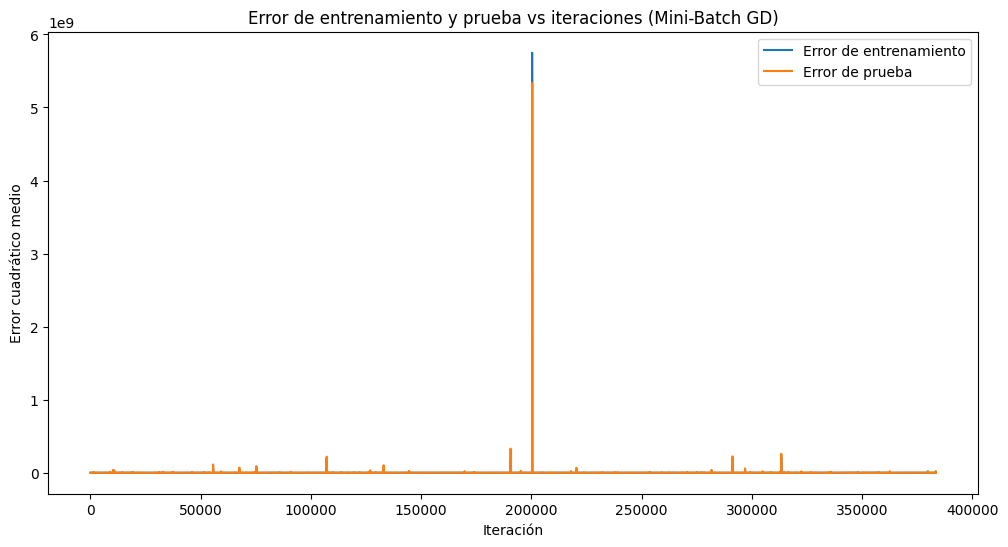

In [ ]:
# Gradiente descendiente Mini Batch

MBGD_coef = mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=300, lr=0.2, batch_size=10)

Lo mismo que para el caso del Gradiente Estocástico, no pudimos obtener un resultado satisfactorio a la hora de minimizar el Error cuadrático medio.

En parte puede estar relacionado a que tanto el mini-batch como el estocástico funcionan mejor en set de datos más grandes comparado al Gradiente descendiente común.

##Regularización

### Ridge Regression

In [ ]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha

modelo = RidgeCV(alphas = np.logspace(-10, 10, 200),
                fit_intercept   = True,
                store_cv_values = True
                )
_ = modelo.fit(X_train_scaled, y_train)

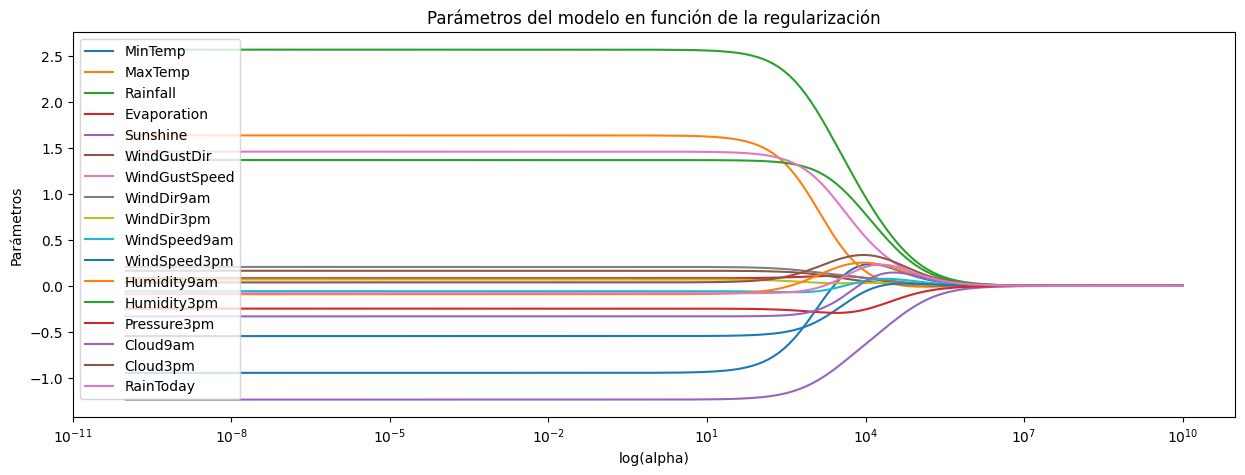

In [ ]:
# Evolución de los parámetros en función de alpha

alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_aux = Ridge(alpha=alpha)
    modelo_aux.fit(X_train_scaled, y_train)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train_df.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

Observamos la evolución de los parámetros en función del alpha. Notamos que a medida que aumenta el alpha, se observa una disminución en la magnitud de los coeficientes. Aquellos parámetros que tienen mayor valor son los últimos en ser armonizados.

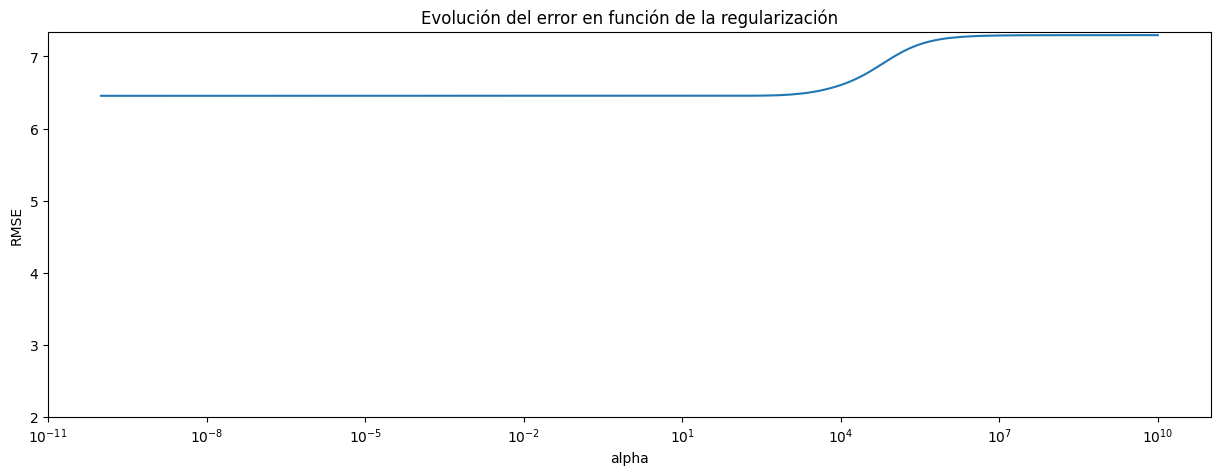

In [ ]:
# Evolución del error de validación cruzada en función de alpha

# modelo.cv_values almacena el MSE de CV para cada valor de alpha.

mod = modelo

mse_cv = mod.cv_values_.reshape((-1, 200)).mean(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
min_rmse     = np.min(rmse_cv)
optimo       = mod.alphas[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(mod.alphas, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

El error comienza a aumentar a partir de un valor de alfa de 10^3 aproximadamente.

In [ ]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 28.66067616948256


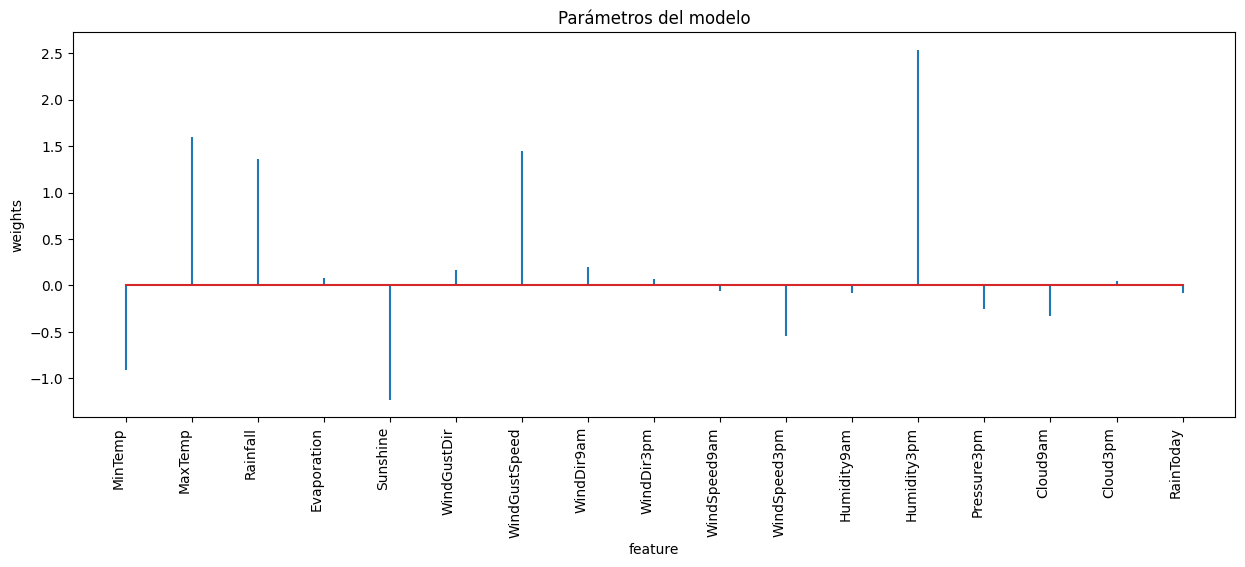

In [ ]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame({'predictor': X_train_df.columns,'coef': mod.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

Notamos como hay ciertos atributos que tienen un peso mucho más importante que otros.

Por ejemplo podemos ver que aquellos con mayor peso son 'Humidity3pm' y 'MaxTemp', mientras que hay algunos otros atributos que su peso nulo.

In [ ]:
# Predicciones test
y_pred = modelo.predict(X_test_scaled)

# Predicciones train
y_pred_train = modelo.predict(X_train_scaled)

In [ ]:
# Error de test del modelo

rmse_ridge = mean_squared_error(y_test,
                y_pred,
                squared = False
             )

print(f"El error (rmse) de test es: {rmse_ridge}")

El error (rmse) de test es: 6.490036085973941


In [ ]:
R2_ridge = metrics.r2_score(y_test, y_pred)
R2_ridge

0.2414619627821022

In [ ]:
R2_ridge_train = metrics.r2_score(y_train, y_pred_train)
R2_ridge_train

0.22091415409431825

Comparando los R2 de train y test, no estamos en presencia de overfitting.

####Explicabilidad SHAP

In [ ]:
# Creamos el objeto explainer SHAP
explainer = shap.LinearExplainer(modelo, X_train_scaled, feature_names=feature_names)

In [ ]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled)

In [ ]:
explainer.expected_value

2.194863263931843

####Interpretabilidad local

Observamos cómo se comporta un dato del conjunto de test.

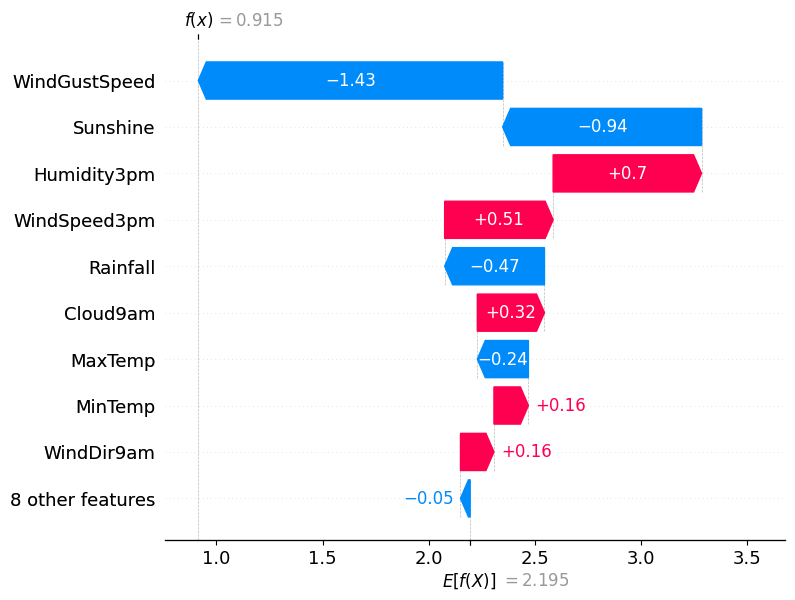

In [ ]:
# Gráfico cascada
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.waterfall(explanation)

En el gráfico de cascada, vemos cómo impacta cada variable explicativa en una predicción en particular.

Se pueden observar resultados muy similares a los arrojados en la Regresión lineal.

#### Interpretabilidad global

Vemos cómo impactan todas las variables explicativas sobre todo el conjunto de test.

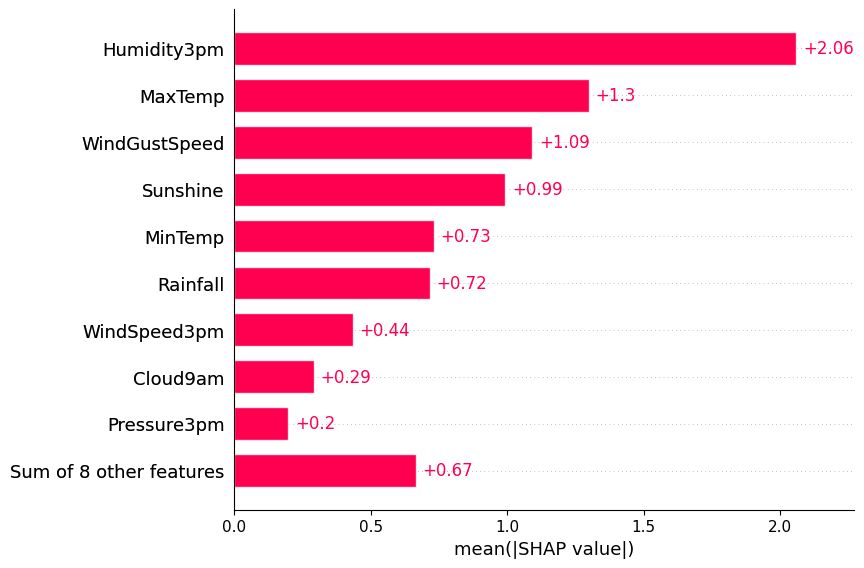

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_scaled)
shap.plots.bar(explanation)

Podemos notar cómo impacta la salida en función de todas las variables explicativas, en promedio.

También se pueden observar resultados muy similares a los arrojados en explicabilidad global para la Regresión lineal.

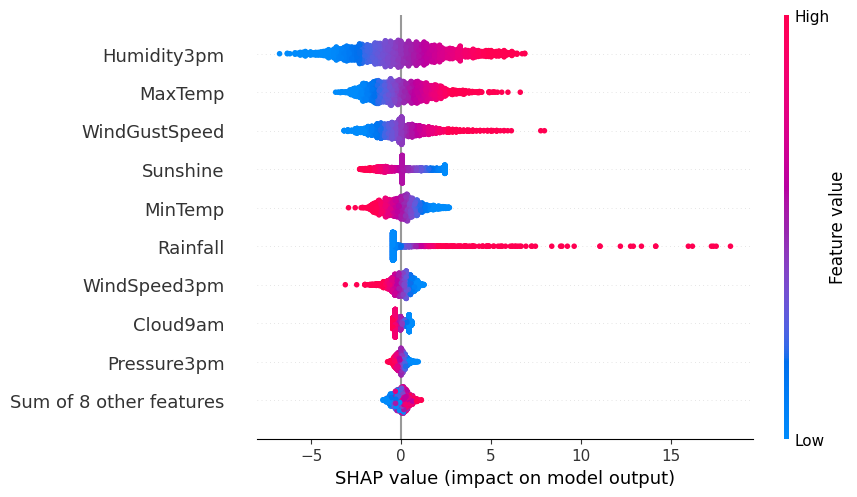

In [ ]:
# Gráfica enjambre de abejas
shap.plots.beeswarm(explanation)



Obtuvimos resultados similares a la Regresión lineal para todas las gráficas de explicabilidad, lo que nos está dando a entender que entre un modelo y otro no hubo grandes cambios en los resultados obtenidos.

Esto también se confirma a la hora de comparar las métricas.

### Lasso Regression

In [ ]:
modelo = LassoCV(alphas=np.logspace(-10, 10, 200),
                 cv=10
                 )

_ = modelo.fit(X_train_scaled, y_train)

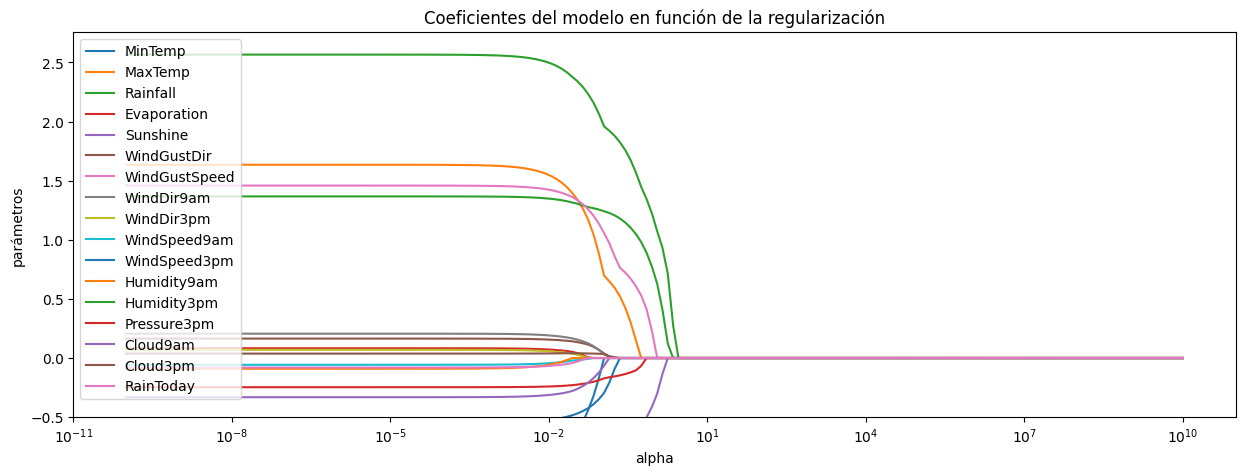

In [ ]:
# Evolución de los parámetros en función de alpha

mod = modelo

alphas = mod.alphas_
coefs = []

for alpha in alphas:
    modelo_aux = Lasso(alpha=alpha)
    modelo_aux.fit(X_train_scaled, y_train)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train_df.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

 Se observa que, a medida que aumenta alpha, algunos coeficientes se vuelven exactamente cero. Esto indica que Lasso puede eliminar algunas características del modelo, en este caso se visualiza que antes de llegar a un valor de alpha de 0.1 ya se han vuelto a 0 varias características, como por ejemplo las velocidades del viento.

Text(0.5, 1.0, 'Features incluidas en función de la regularización')

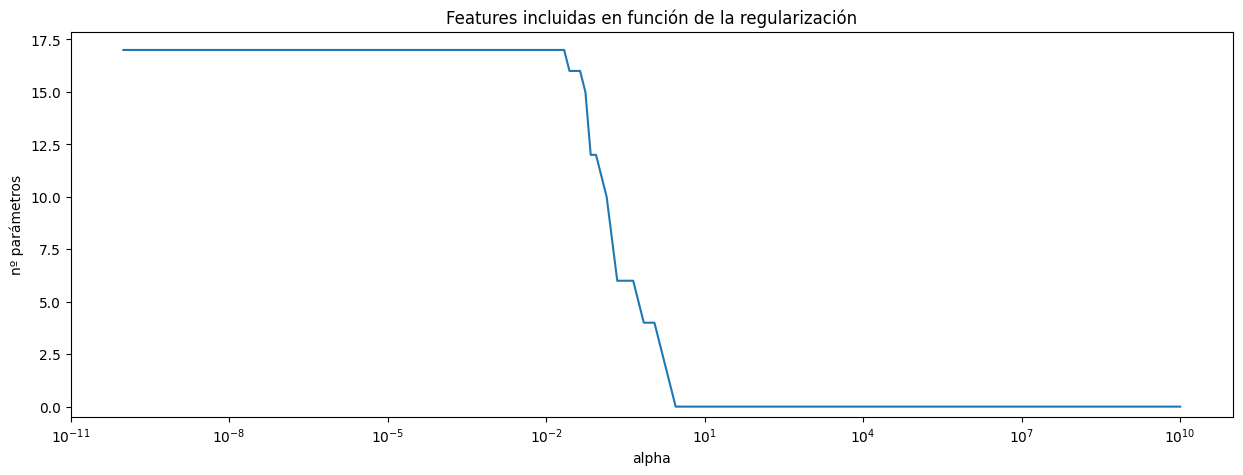

In [ ]:
# Número de features incluidas (parámetros !=0) en función de alpha
alphas = mod.alphas_
n_predictores = []

for alpha in alphas:
    modelo_aux = Lasso(alpha=alpha)
    modelo_aux.fit(X_train_scaled, y_train)
    coef_no_cero = np.sum(modelo_aux.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº parámetros')
ax.set_title('Features incluidas en función de la regularización')

En esta gráfica se puede notar mejor la cantidad de features que se incluyen en función del alpha.

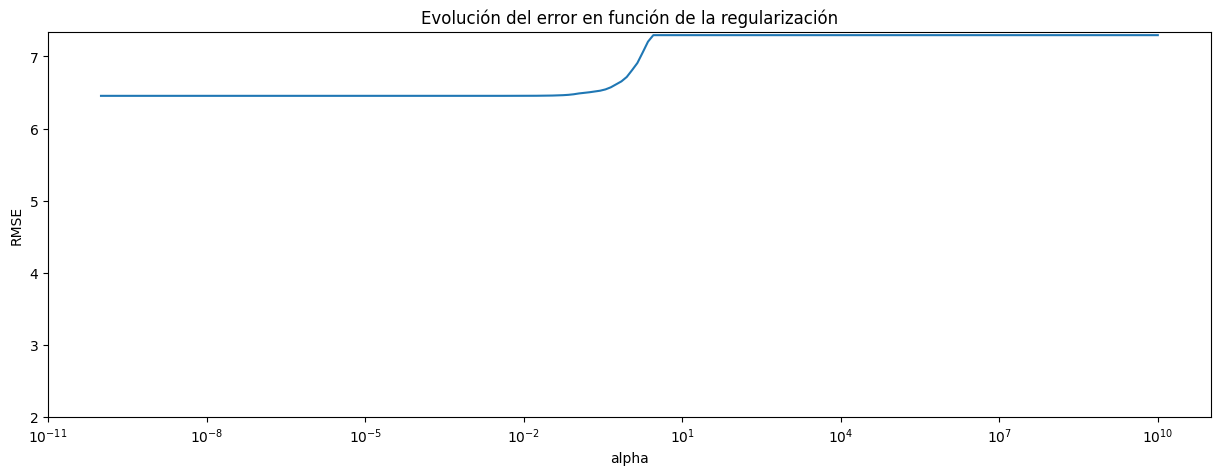

In [ ]:
# Evolución del error de validación cruzada en función de alpha

# modelo.mse_path almacena el MSE de CV para cada valor de alpha.

mse_cv = mod.mse_path_.mean(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
min_rmse     = np.min(rmse_cv)
optimo       = mod.alphas_[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(mod.alphas_, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

Se puede notar que el error comienza a aumentar a partir de un alpha de 0.1 aproximadaente.

In [ ]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 1.2603829296797273e-10


In [ ]:
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train_df.columns,
                         'coef': mod.coef_.flatten()}
                  )

df_coeficientes[df_coeficientes.coef != 0]

predictor      coef
0         MinTemp -0.945416
1         MaxTemp  1.634978
2        Rainfall  1.367125
3     Evaporation  0.082779
4        Sunshine -1.235934
5     WindGustDir  0.164356
6   WindGustSpeed  1.458699
7      WindDir9am  0.205913
8      WindDir3pm  0.069542
9    WindSpeed9am -0.057293
10   WindSpeed3pm -0.545893
11    Humidity9am -0.090882
12    Humidity3pm  2.566590
13    Pressure3pm -0.247044
14       Cloud9am -0.331659
15       Cloud3pm  0.037339
16      RainToday -0.080508

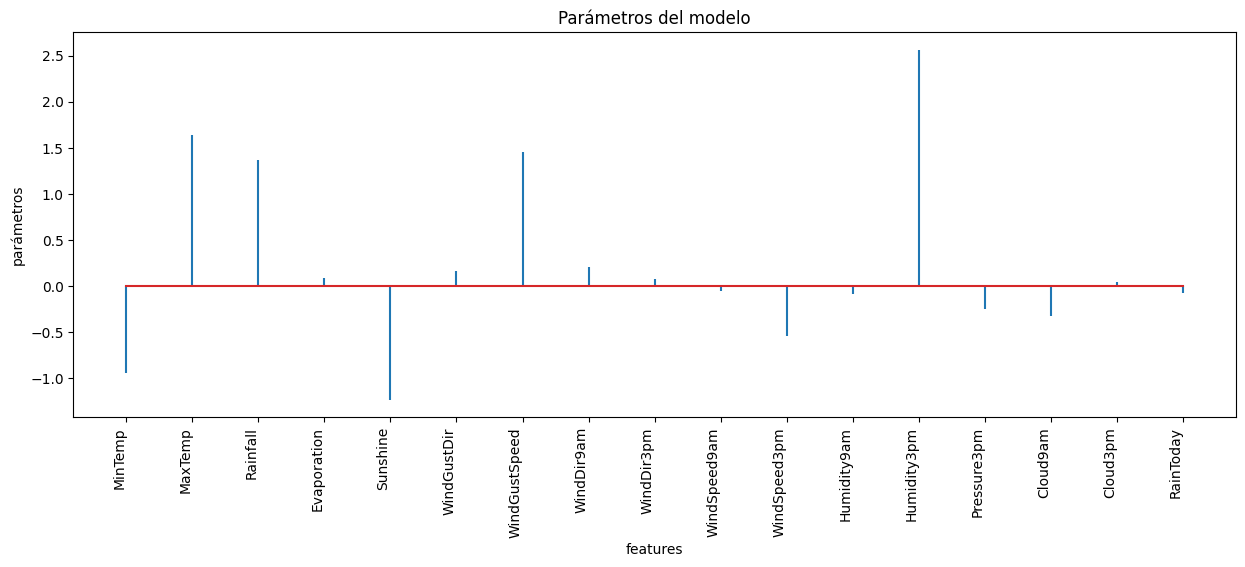

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [ ]:
y_pred = modelo.predict(X_test_scaled)

In [ ]:
# Error de test del modelo

rmse_lasso = mean_squared_error(y_test,y_pred,squared = False)
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 6.489714018308792


In [ ]:
R2_lasso = metrics.r2_score(y_test, y_pred)
R2_lasso

0.24153724572649138

####Explicabilidad SHAP

In [ ]:
# Creamos el objeto explainer SHAP
explainer = shap.LinearExplainer(modelo, X_train_scaled, feature_names=feature_names)

In [ ]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled)

In [ ]:
explainer.expected_value

2.194718998540162

####Interpretabilidad local

Observamos cómo se comporta un dato del conjunto de test.

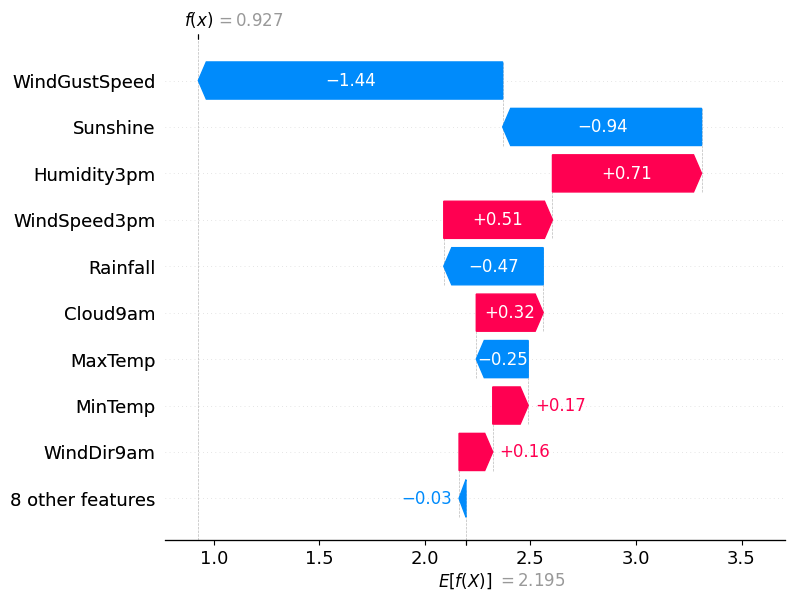

In [ ]:
# Gráfico cascada
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.waterfall(explanation)

En el gráfico de cascada, vemos cómo impacta cada variable explicativa en una predicción en particular.

Se pueden observar resultados muy similares a los arrojados en la Regresión lineal y en Ridge.

#### Interpretabilidad global

Vemos cómo impactan todas las variables explicativas sobre todo el conjunto de test.

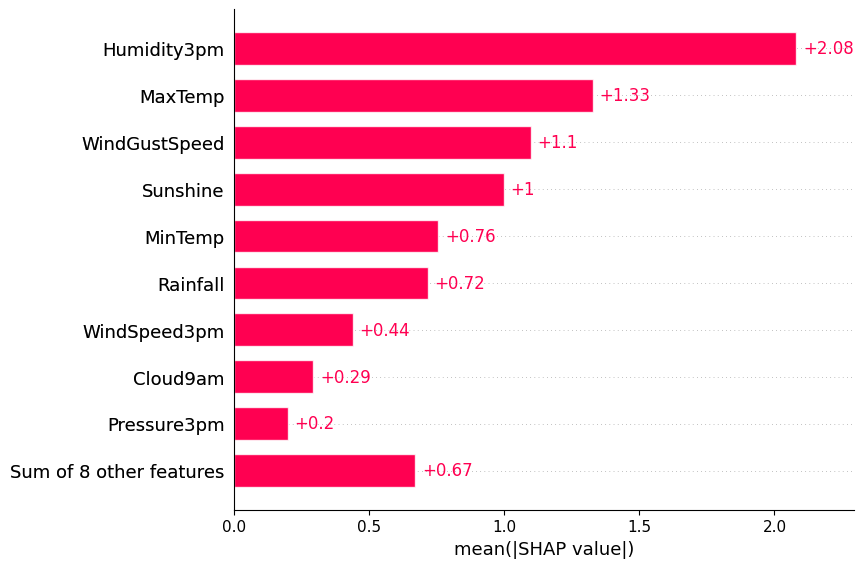

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_scaled)
shap.plots.bar(explanation)

Podemos notar cómo impacta la salida en función de todas las variables explicativas, en promedio.

También se pueden observar resultados muy similares a los arrojados en explicabilidad global para la Regresión lineal y Ridge.

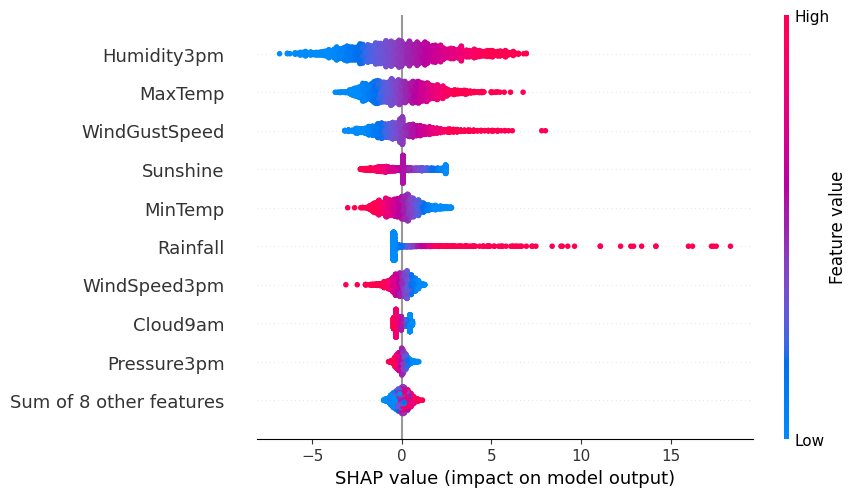

In [ ]:
# Gráfica enjambre de abejas
shap.plots.beeswarm(explanation)



Obtuvimos resultados similares a la Regresión lineal y a Ridge para todas las gráficas de explicabilidad, lo que nos está dando a entender que entre los modelos hubo grandes cambios en los resultados obtenidos.

Esto también se confirma a la hora de comparar las métricas.

### ElasticNet

In [ ]:
modelo = ElasticNetCV(l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                      alphas = np.logspace(-10, 10, 200),
                      cv = 10
                      )

_ = modelo.fit(X_train_scaled, y_train)

mod = modelo

In [ ]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = mod.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [mod.l1_ratio, mod.alphas_],
                                    names     = ['l1_ratio', 'mod.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

l1_ratio   mod.alphas_     mse_cv   rmse_cv
126       0.00  2.171118e-03  41.656412  6.454178
125       0.00  2.736440e-03  41.656420  6.454178
127       0.00  1.722586e-03  41.656442  6.454180
326       0.10  2.171118e-03  41.656471  6.454182
325       0.10  2.736440e-03  41.656486  6.454184
...        ...           ...        ...       ...
1027      0.95  1.933892e+07  53.224104  7.295485
1028      0.95  1.534368e+07  53.224104  7.295485
1029      0.95  1.217383e+07  53.224104  7.295485
1023      0.95  4.880252e+07  53.224104  7.295485
1053      0.95  4.713753e+04  53.224104  7.295485

[1400 rows x 4 columns]

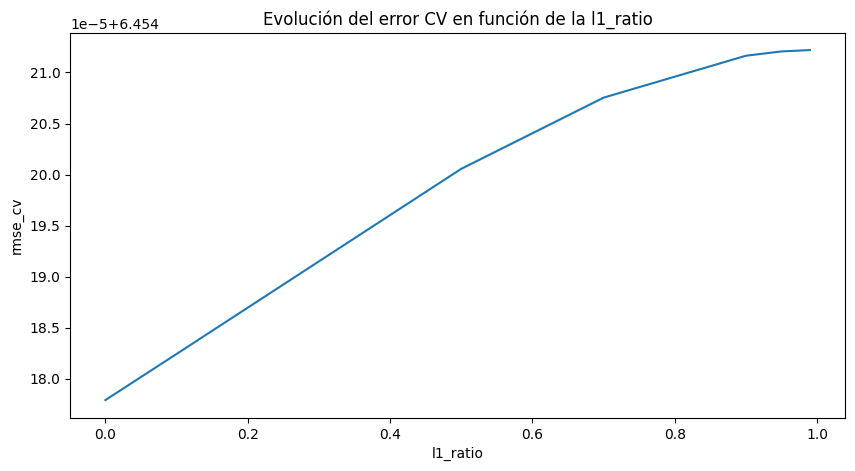

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

Vemos que el error 'rmse' aumenta a medida que aumentamos el l1_ratio del modelo, con un óptimo del valor de l1_ratio=0.

Esto puede indicar que la regularización L1 no está teniendo efecto, y el modelo se está comportando más como un modelo de Ridge.

In [ ]:
# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {mod.l1_ratio_}")

Mejor valor de alpha encontrado: 0.002171117945694505
Mejor valor de l1_ratio encontrado: 0.0


In [ ]:
# Predicciones test
y_pred = modelo.predict(X_test_scaled)

In [ ]:
# Error de test del modelo

rmse_elastic = mean_squared_error(y_test,y_pred, squared = False)
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")


El error (rmse) de test es: 6.4900249779067956


In [ ]:
R2_elastic_net = metrics.r2_score(y_test, y_pred)
R2_elastic_net

0.24146455934216038

Para ElasticNet decidimos no realizar explicabilidad SHAP ya que como venimos viendo, los resultados están dando todos muy similares, por lo tanto iba a ser muy redundante.

Decidimos también, no realizar optimización de hiperparámetros para los modelos de Regularización, ya que éstos de por sí aplican CV para elegir los mismos a la hora de instanciar el modelo.

## Red Neuronal

Realizamos un nuevo split del conjunto de test para obtener un subconjunto de validación para los modelos de redes neuronales.
La división final resulta:

* 85%  -> Train
* 7,5% -> Validación
* 7,5% -> Test

In [ ]:
# Conjuntos de validación
X_valid_reg, X_test_reg, y_valid_reg, y_test_reg = train_test_split(X_test_scaled, y_test, test_size=0.5, random_state = 12)

### Modelo I - Hiperparámetros seleccionados manualmente

Hiperparámetros:

* 2 capas ocultas
* 10 neuronas por capa
* Función de activación: ReLu
* Función de activación de capa de salida: lineal
* Función de pérdida: MSE
* Épocas: 30
* Métrica: R2


In [ ]:
# Instanciamos el modelo
model_nn_reg = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])
model_nn_reg

Al no especificar la función de activación en la capa de salida, ésta se considerara lineal. Es lo que queremos para un problema de regresión.

In [ ]:
model_nn_reg.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.R2Score()])

In [ ]:
historial_entrenamiento = model_nn_reg.fit(X_train_scaled, y_train, batch_size=32, epochs=30, validation_data=(X_valid_reg, y_valid_reg))

Epoch 1/30
400/400 [==============================] - 8s 4ms/step - loss: 50.0170 - r2_score: 0.0601 - val_loss: 45.5733 - val_r2_score: 0.1823
Epoch 2/30
400/400 [==============================] - 1s 4ms/step - loss: 42.4928 - r2_score: 0.2015 - val_loss: 43.4023 - val_r2_score: 0.2213
Epoch 3/30
400/400 [==============================] - 2s 5ms/step - loss: 40.5971 - r2_score: 0.2371 - val_loss: 42.2384 - val_r2_score: 0.2422
Epoch 4/30
400/400 [==============================] - 3s 8ms/step - loss: 39.4647 - r2_score: 0.2584 - val_loss: 41.1686 - val_r2_score: 0.2614
Epoch 5/30
400/400 [==============================] - 3s 7ms/step - loss: 38.7686 - r2_score: 0.2715 - val_loss: 41.0749 - val_r2_score: 0.2630
Epoch 6/30
400/400 [==============================] - 3s 6ms/step - loss: 38.3330 - r2_score: 0.2797 - val_loss: 40.1038 - val_r2_score: 0.2805
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 37.8318 - r2_score: 0.2891 - val_loss: 40.0871 - val_r2_score:

In [ ]:
# Resumen del modelo

model_nn_reg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                180       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 301 (1.18 KB)
Trainable params: 301 (1.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Métricas de validación
loss, r2 = model_nn_reg.evaluate(X_valid_reg, y_valid_reg)
print(f'Pérdida validación: {loss}')
print(f'R2 validación: {r2}')

36/36 [==============================] - 0s 2ms/step - loss: 37.1478 - r2_score: 0.3335
Pérdida validación: 37.14780044555664
R2 validación: 0.3334956169128418


In [ ]:
# Predicciones test
y_pred_nn = model_nn_reg.predict(X_test_reg)

# Predicciones train
y_pred_train_nn = model_nn_reg.predict(X_train_scaled)

400/400 [==============================] - 1s 2ms/step


#### Métricas del modelo con el conjunto de test y train

In [ ]:
# Test
R2_nn = metrics.r2_score(y_test_reg, y_pred_nn)
print(f'R2 del conjunto de test: {R2_nn.round(3)}')

R2 del conjunto de test: 0.379


In [ ]:
# Train
R2_nn_train = metrics.r2_score(y_train, y_pred_train_nn)
print(f'R2 del conjunto de train: {R2_nn_train.round(3)}')

R2 del conjunto de train: 0.345


R2 de test supera al de train, significa que no estamos en presencia de overfitting.

Gráfica Pérdida vs Epochs para optimizar nº de epochs

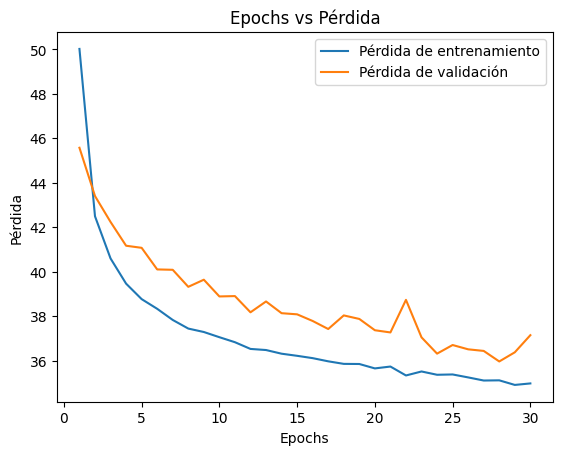

In [ ]:
# Extraemos la pérdida de entrenamiento y la pérdida de validación del historial
pérdida_entrenamiento = historial_entrenamiento.history['loss']
pérdida_validación = historial_entrenamiento.history['val_loss']

# Creamos la gráfica de las epochs versus la pérdida
epochs = range(1, len(pérdida_entrenamiento) + 1)
plt.plot(epochs, pérdida_entrenamiento, label='Pérdida de entrenamiento')
plt.plot(epochs, pérdida_validación, label='Pérdida de validación')
plt.title('Epochs vs Pérdida')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Se puede ver como la pérdida disminuye a medida que aumentan las épocas. Decidimos que 30 epochs es un número razonable, ya que el r2 que obtuvimos es satisfactorio con respecto al obtenido en los otros modelos.

### Optimización de hiperparámetros

Decidimos utilizar Optuna para optimizar los hiperparámetros de la red neuronal ya que es útil cuando el espacio de búsqueda es grande y puede manejar de manera efectiva la optimización de hiperparámetros para modelos de aprendizaje profundo.

In [ ]:
def objective(trial):

    num_layers = trial.suggest_int('num_layers', 1, 5)
    model = Sequential()

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128) # cantidad de neuronas de cada capa
        # activations = trial.suggest_categorical(f'')
        model.add(Dense(num_units, activation='relu')) # capas densas con activación ReLU

    # capa de salida
    model.add(Dense(1)) # 1 clase de salida

    # compilar
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.R2Score()])

    # entrenar
    model.fit(X_train_scaled, y_train, validation_data=(X_valid_reg, y_valid_reg), epochs=30, batch_size=32, verbose=0)

    # evaluar
    loss, r2 = model.evaluate(X_valid_reg, y_valid_reg, verbose=0)
    return r2

# crear un estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores parámetros encontrados:", best_params)

15 iteraciones (12min):

Mejores parámetros encontrados: {'num_layers': 2, 'n_units_layer_0': 11, 'n_units_layer_1': 114}

A partir de la utilización de Optuna, obtuvimos los mejores hiperparámetros para el modelo.

Estos fueron:
* 2 capas
* Capa 0: 11 neuronas
* Capa 1: 114 neuronas



### Modelo II - Hiperparámetros optimizados

In [ ]:
model_nn_reg_opt = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(114, activation='relu'),
    # tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

model_nn_reg_opt.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.R2Score()])

historial_entrenamiento = model_nn_reg_opt.fit(X_train_scaled, y_train, batch_size=32, epochs=20, validation_data=(X_valid_reg, y_valid_reg))

Epoch 1/20
400/400 [==============================] - 3s 4ms/step - loss: 45.6154 - r2_score: 0.1428 - val_loss: 42.9825 - val_r2_score: 0.2288
Epoch 2/20
400/400 [==============================] - 1s 4ms/step - loss: 40.0163 - r2_score: 0.2481 - val_loss: 41.6178 - val_r2_score: 0.2533
Epoch 3/20
400/400 [==============================] - 2s 5ms/step - loss: 38.4610 - r2_score: 0.2773 - val_loss: 39.9878 - val_r2_score: 0.2825
Epoch 4/20
400/400 [==============================] - 2s 5ms/step - loss: 37.3812 - r2_score: 0.2976 - val_loss: 38.4434 - val_r2_score: 0.3102
Epoch 5/20
400/400 [==============================] - 1s 4ms/step - loss: 36.7492 - r2_score: 0.3094 - val_loss: 38.1756 - val_r2_score: 0.3151
Epoch 6/20
400/400 [==============================] - 2s 6ms/step - loss: 36.2661 - r2_score: 0.3185 - val_loss: 37.6879 - val_r2_score: 0.3238
Epoch 7/20
400/400 [==============================] - 3s 7ms/step - loss: 35.8044 - r2_score: 0.3272 - val_loss: 36.8535 - val_r2_score:

In [ ]:
# Métricas de validación
loss, r2 = model_nn_reg_opt.evaluate(X_valid_reg, y_valid_reg)
print(f'Pérdida test: {loss}')
print(f'R2 test: {r2}')

36/36 [==============================] - 0s 2ms/step - loss: 34.7729 - r2_score: 0.3761
Pérdida test: 34.77286911010742
R2 test: 0.3761065602302551


In [ ]:
# Predicciones test
y_pred_nn = model_nn_reg_opt.predict(X_test_reg)

# Predicciones train
y_pred_train_nn = model_nn_reg_opt.predict(X_train_scaled)

400/400 [==============================] - 1s 2ms/step


#### Métricas del modelo con el conjunto de test y train

In [ ]:
# Test
R2_nn_opt = metrics.r2_score(y_test_reg, y_pred_nn)
print(f'R2 del conjunto de test: {R2_nn_opt.round(3)}')

# Train
R2_nn_train = metrics.r2_score(y_train, y_pred_train_nn)
print(f'R2 del conjunto de train: {R2_nn_train.round(3)}')

R2 del conjunto de test: 0.366
R2 del conjunto de train: 0.403


El modelo optimizado obtenido no presenta overfitting.

Gráfica Pérdida vs Epochs para optimizar nº de epochs

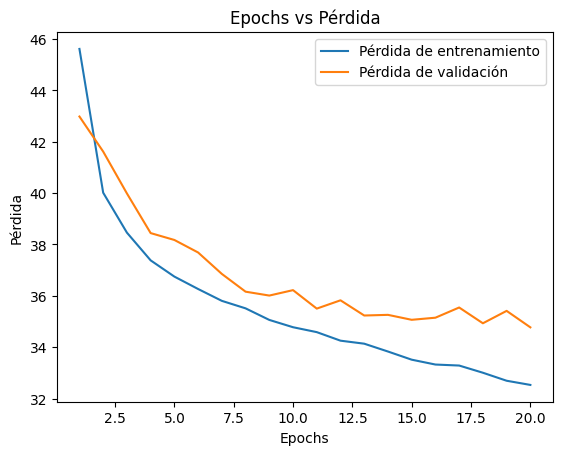

In [ ]:
# Extraemos la pérdida de entrenamiento y la pérdida de validación del historial
pérdida_entrenamiento = historial_entrenamiento.history['loss']
pérdida_validación = historial_entrenamiento.history['val_loss']

# Creamos la gráfica de las epochs versus la pérdida
epochs = range(1, len(pérdida_entrenamiento) + 1)
plt.plot(epochs, pérdida_entrenamiento, label='Pérdida de entrenamiento')
plt.plot(epochs, pérdida_validación, label='Pérdida de validación')
plt.title('Epochs vs Pérdida')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

###Explicabilidad SHAP

In [ ]:
# Creamos el objeto explainer SHAP
explainer = shap.Explainer(model_nn_reg_opt, X_train_scaled, feature_names=feature_names)

In [ ]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_reg)

PermutationExplainer explainer: 1129it [00:26, 29.09it/s]                          


####Interpretabilidad local

Observamos cómo se comporta un dato del conjunto de test.

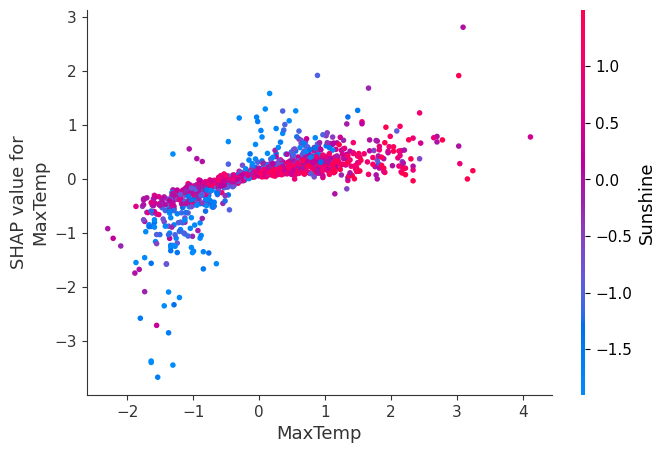

In [ ]:
# Gráfico de dependencias
shap.dependence_plot('MaxTemp', shap_values, X_test_reg, feature_names=feature_names)

El gráfico de dependencias muestra la relación entre el valor SHAP de una característica y la contribución al resultado para una observación específica.

Podemos notar para el caso de la variable 'MaxTemp' que, para valores bajos de esta característica, el valor SHAP varía mucho, por lo tanto necesito de otra variable, que en este caso es 'Humidity3pm' para poder explicar mejor, en donde se observa como va aumentando la humedad a medida que el SHAP value de 'MaxTemp' es mas bajo. Para valores más altos de este atributo ocurre lo contrario.

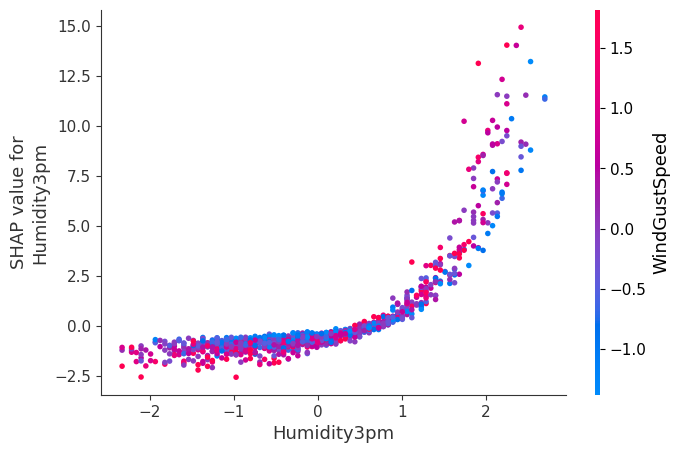

In [ ]:
shap.dependence_plot('Humidity3pm', shap_values, X_test_reg, feature_names=feature_names)


Para la variable explicativa 'Humidity3pm' notamos que tendremos menos lluvia cuando 'Sunshine' es alto y la humedad es baja. Se observa una tendencia de que a medida que disminuye el valor de 'Sunshine', las humedades son más altas.

#### Interpretabilidad global

Vemos cómo impactan todas las variables explicativas sobre todo el conjunto de test.

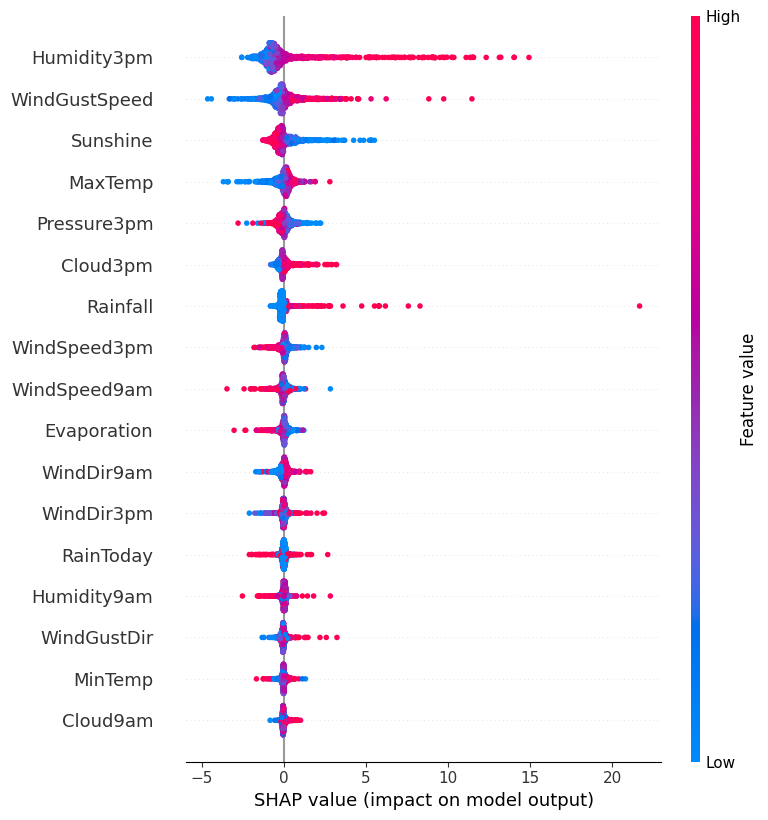

In [ ]:
# Gráfica enjambre de abejas
shap.summary_plot(shap_values, X_test_reg, feature_names=feature_names)

Vemos el impacto que ocurre en la predicción para valores altos y bajos de las variables explicativas, y cómo están distribuidos los puntos para cada una.

Por ejemplo, se puede observar que, mientras más baja es 'Humidity3pm', menor cantidad de lluvia se va a tener para el día siguiente, y mientras más alta es esta variable, mayor cantidad de lluvia se tendrá. Se puede ver también que los puntos están mas concentrados valores de humedades bajas.

## Comparación de modelos de Regresión

Decidimos tomar como referencia la métrica de R2 para comparar los modelos de regresión.

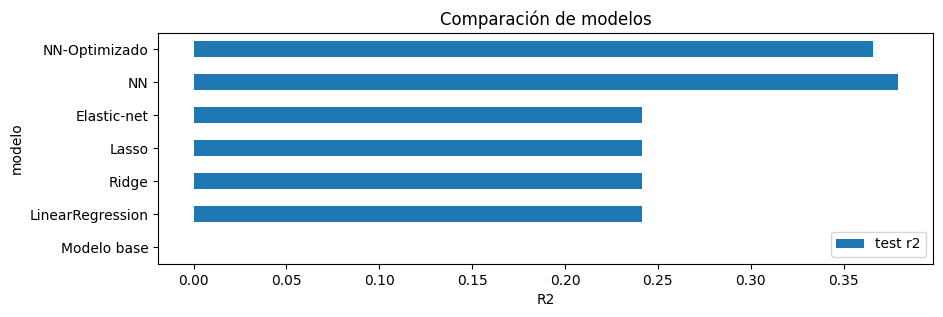

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['Modelo base', 'LinearRegression', 'Ridge', 'Lasso', 'Elastic-net', 'NN','NN-Optimizado'],
                    'test r2': [R2_base, R2, R2_ridge, R2_lasso, R2_elastic_net, R2_nn, R2_nn_opt]
                 })

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('R2')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

Claramente se puede notar que el R2 en el modelo de Red Neuronal es bastante superior, dando como resultado un valor de 0.38 aprox.

En todos los otros modelos se ha obtenido el mismo valor de esta métrica, alrededor de 0.24

El modelo optmizado presenta una leve mejora respecto al generado con parámetros seleccionados manualmente.

El modelo no optimizado es más simple ya que presenta menor cantidad de neuronas, por lo que resultaría aceptable considerando el balance entre el resultado obtenido y el costo computacional.

# Clasificación

## Split del dataset

Realizamos un nuevo split del conjunto de datos ya que para la clasificación utilizamos un 'y' distinto

* 80%  -> Train
* 20% -> Test

In [ ]:
### División de los datos en train y test

X = df_sel.drop(columns=['RainfallTomorrow','RainTomorrow','Date', 'Location'])
y_clf = df_sel['RainTomorrow']

X_train_clf, X_test_clf, y_clf_train, y_clf_test = train_test_split(X, y_clf.values, test_size=0.2, random_state = 12)

In [ ]:
X_train_clf.shape, X_test_clf.shape

((12028, 20), (3008, 20))

##Ingeniería de características

In [ ]:
# Vamos a imputar los datos faltantes del mismo modo que hicimos en el caso de la Regresión.

col = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
# Imputamos datos categóricos por la moda
X_train_clf, X_test_clf = imputar_moda(X_train_clf, X_test_clf, col)

# Imputamos datos numéricos por la media
X_train_clf, X_test_clf = imputar_media(X_train_clf, X_test_clf)

In [ ]:
# Dropeamos las mismas columnas que en el caso anterior
X_train_clf.drop(columns = ['Temp9am','Temp3pm','Pressure9am'], inplace = True)

X_test_clf.drop(columns = ['Temp9am','Temp3pm','Pressure9am'], inplace = True)

In [ ]:
# Escalamos los datos
X_train_clf_scaled, X_test_clf_scaled = escalar_datos(X_train_clf, X_test_clf)

In [ ]:
X_train_clf.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  \
0     10.7     22.7       0.0          6.0       6.3          3.0   
1     19.2     28.1       0.0          9.4       4.3          3.0   
2      5.0     13.8       3.8          2.8      10.0          9.0   
3     14.0     21.7       0.0         12.2      11.4         11.0   
4     14.2     23.9       0.0          4.0       4.9          1.0   

   WindGustSpeed  WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  \
0           39.0         3.0        10.0          22.0           9.0   
1           41.0         1.0         2.0           7.0          26.0   
2           52.0         8.0         6.0          17.0          37.0   
3           41.0        11.0        14.0          17.0          22.0   
4           83.0         1.0         1.0          54.0          33.0   

   Humidity9am  Humidity3pm  Pressure3pm  Cloud9am  Cloud3pm  RainToday  
0         75.0         44.0       1009.6       1.0       7.0        0.0  
1         65.0         59.0       1013.8       7.0       7.0        0.0  
2         84.0         38.0       1024.7       3.0       3.0        1.0  
3         30.0         32.0       1016.5       0.0       0.0        0.0  
4         48.0         41.0       1022.4       5.0       7.0        0.0

## Modelo base de clasificación

Creamos modelo base basado en la mayoría ya que tenemos clases desbalanceadas.

El resultado que devuelve el modelo corresponde a la moda del dataset de entrenamiento.

In [ ]:
vals,counts = np.unique(y_clf_train, return_counts=True)
mayoritaria = np.argmax(counts)

# Modelo base basado en la mayoría
def modelo_base_mayoria(df):
    return [mayoritaria] * len(df)

predicciones_base_clf = modelo_base_mayoria(X_test_clf_scaled)

print("Predicciones del modelo base:")
print(predicciones_base_clf)



Predicciones del modelo base:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Métricas modelo base clasificación
print("Resultados modelo base:\n")
clf_report_base = classification_report(y_clf_test, predicciones_base_clf)
print(clf_report_base)
print(confusion_matrix(y_clf_test, predicciones_base_clf))

Resultados modelo base:

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87      2309
         1.0       0.00      0.00      0.00       699

    accuracy                           0.77      3008
   macro avg       0.38      0.50      0.43      3008
weighted avg       0.59      0.77      0.67      3008

[[2309    0]
 [ 699    0]]


Métricas del modelo base (mínimo esperable de nuestros modelos):


* Precision Clase 0: 0.77
* F1-Score Clase 0 : 0.87


##Regresión Logística

In [ ]:
# Inicializamos y entrenamos el modelo de regresión logística
reg_log = LogisticRegression(random_state=42, solver='liblinear')
reg_log.fit(X_train_clf_scaled, y_clf_train)

LogisticRegression(random_state=42, solver='liblinear')

In [ ]:
# Predicciones en el conjunto de test
y_pred_test = reg_log.predict(X_test_clf_scaled)

# Predicciones en el conjunto de train
y_pred_train = reg_log.predict(X_train_clf_scaled)


In [ ]:
# Métricas para el conj de test
clf_report_test = classification_report(y_clf_test, y_pred_test)
print(clf_report_test)

cm_test = confusion_matrix(y_clf_test, y_pred_test)
print('Matriz de confusión:')
print(cm_test)

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      2309
         1.0       0.70      0.50      0.58       699

    accuracy                           0.83      3008
   macro avg       0.78      0.72      0.74      3008
weighted avg       0.82      0.83      0.82      3008

Matriz de confusión:
[[2160  149]
 [ 351  348]]


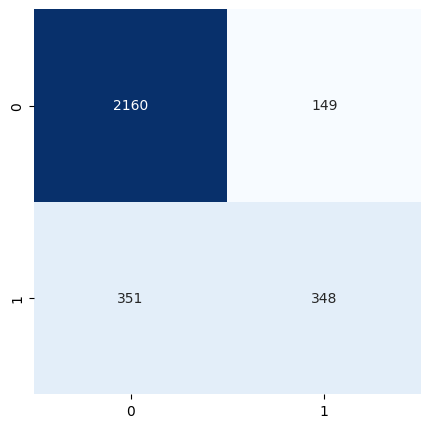

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(cm_test, cbar=False, cmap='Blues', annot=True, fmt="d")
plt.show()

Nos enfocaremos en la Precisión, Recall y F1, ya que estamos trabajando en el dataset que está desbalanceado

A partir del reporte de métricas observamos que tenemos buenos valores de Precisión, Recall y F1 score para la clase 0 (No llueve), que es donde mas datos tenemos. Es decir, para esa clase la regresión logística está funcionando bastante bien.

Para la clase 1 (Llueve) tenemos valores bastante mas bajos para estas métricas. Procederemos luego a realizar un balance del dataset.

Para la comparación de modelos, nos centraremos en la Precisión de la Clase 0.

Es decir, queremos enfocarnos en predecir de forma adecuada los días que no van a llover.

### Chequeo de overfitting o underfitting
Obtenemos las métricas para el conjunto de entrenamiento y comparamos con las del conjunto de test

In [ ]:
clf_report_train = classification_report(y_clf_train, y_pred_train)
print(clf_report_train)

cm_train = confusion_matrix(y_clf_train, y_pred_train)
print('Matriz de confusión:')
print(cm_train)

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      9284
         1.0       0.72      0.49      0.59      2744

    accuracy                           0.84     12028
   macro avg       0.79      0.72      0.74     12028
weighted avg       0.83      0.84      0.83     12028

Matriz de confusión:
[[8757  527]
 [1390 1354]]


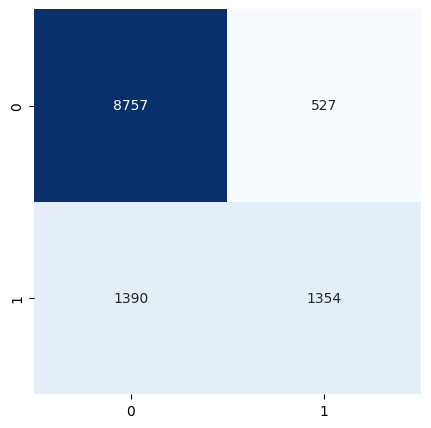

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(cm_train, cbar=False, cmap='Blues', annot=True, fmt="d")
plt.show()

### Comparación conjunto de test y train

In [ ]:
# Reporte de test
print('Métricas de test:')
print(clf_report_test)
print('-----------------------')
print('Métricas de train:')
# Reporte de train
print(clf_report_train)

Métricas de test:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      2309
         1.0       0.70      0.50      0.58       699

    accuracy                           0.83      3008
   macro avg       0.78      0.72      0.74      3008
weighted avg       0.82      0.83      0.82      3008

-----------------------
Métricas de train:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      9284
         1.0       0.72      0.49      0.59      2744

    accuracy                           0.84     12028
   macro avg       0.79      0.72      0.74     12028
weighted avg       0.83      0.84      0.83     12028



Notamos que tanto la precisión, el recall y el F1 score del conjunto de entrenamiento y del conjunto de test son valores bastante comparables. Por lo tanto concluimos que no se presenta overfitting.

### Curva ROC

In [ ]:
# Obtengo las probabilidades de predicción del modelo
y_probs = reg_log.predict_proba(X_test_clf_scaled)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_clf_test, y_probs)
roc_auc = auc(fpr, tpr)

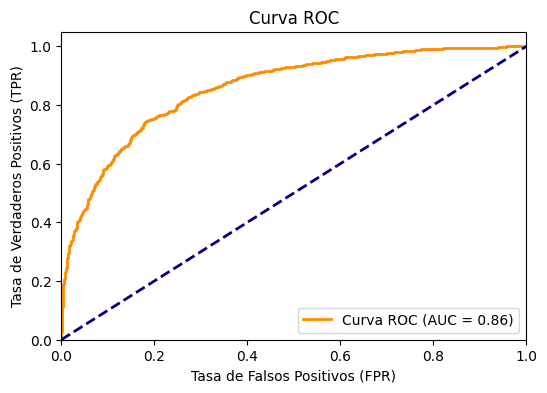

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc

0.8581379945736995

Se obtuvo un valor de 0.86 para el AUC de la Curva ROC, donde notamos que a bajos valores de la Tasa de FP (FPR), obtuvimos valores bastante satisfactoios para la Tasa de TP (TPR).

## Regresión Logística con balance del dataset

### RandomOverSampler

In [ ]:
oversampler = RandomOverSampler(random_state=42)
X_resampled_clf, y_resampled_clf = oversampler.fit_resample(X_train_clf_scaled, y_clf_train)

In [ ]:
# Convertimos en DataFrame
X_resampled_clf = pd.DataFrame(X_resampled_clf, columns=X_train_clf.columns)

In [ ]:
len(y_resampled_clf[y_resampled_clf==1]), len(y_resampled_clf[y_resampled_clf==0])

(9284, 9284)

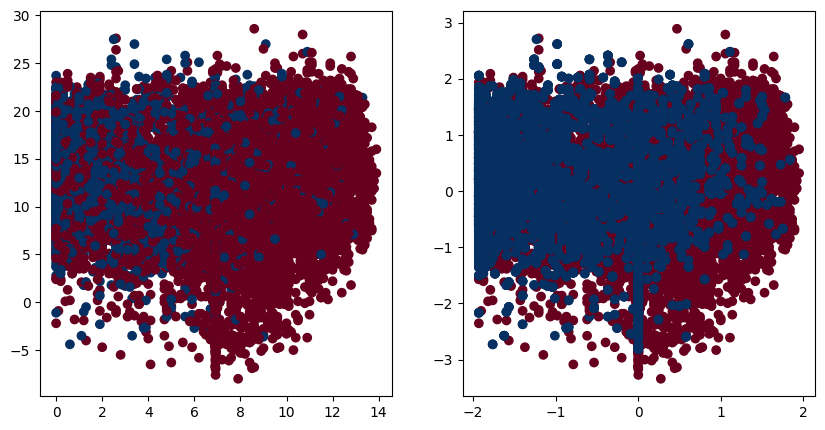

In [ ]:
### Hacemos dos gráficas, la de la izquierda tendrá los datos sin resamplear y la de la derecha los datos resampleados.
### Lo vamos a ver solo con dos features porque sino es imposible de graficar.

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(X_train_clf['Sunshine'], X_train_clf['MinTemp'], c=y_clf_train, cmap=plt.cm.RdBu)
ax[1].scatter(X_resampled_clf['Sunshine'], X_resampled_clf['MinTemp'], c=y_resampled_clf, cmap=plt.cm.RdBu)
plt.show()

Observamos los cambios que hubo en la gráfica resampleada con la gráfica con los datos originales. Esto es debido a que tenemos nuevas muestras.

In [ ]:
# Regresión logística con el balance de clases
reg_log.fit(X_resampled_clf, y_resampled_clf)
y_pred = reg_log.predict(X_test_clf_scaled)

cm_test_oversamp = confusion_matrix(y_clf_test, y_pred)

print("Resultados regresión logística con Oversampling:\n")
clf_report_over = classification_report(y_clf_test, y_pred)
print(clf_report_over)
print(confusion_matrix(y_clf_test, y_pred))

Resultados regresión logística con Oversampling:

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85      2309
         1.0       0.52      0.77      0.62       699

    accuracy                           0.78      3008
   macro avg       0.72      0.78      0.73      3008
weighted avg       0.83      0.78      0.80      3008

[[1820  489]
 [ 163  536]]


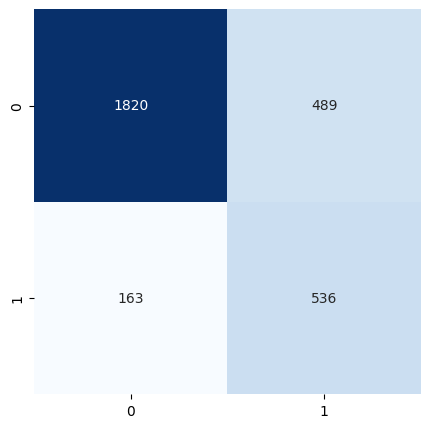

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(cm_test_oversamp, cbar=False, cmap='Blues', annot=True, fmt="d")
plt.show()

Observamos que aplicando un balance de dataset con RandomOverSampler, la Precisión de la clase 0 ha aumentado bastante, dando como resultado un valor de 0.92.

### RandomUnderSampler

In [ ]:
undersampler = RandomUnderSampler(random_state=42)
X_resampled_clf2, y_resampled_clf2 = undersampler.fit_resample(X_train_clf_scaled, y_clf_train)

In [ ]:
# Convertimos en DataFrame
X_resampled_clf2 = pd.DataFrame(X_resampled_clf2, columns=X_train_clf.columns)

In [ ]:
len(y_resampled_clf2[y_resampled_clf2==1]), len(y_resampled_clf2[y_resampled_clf2==0])

(2744, 2744)

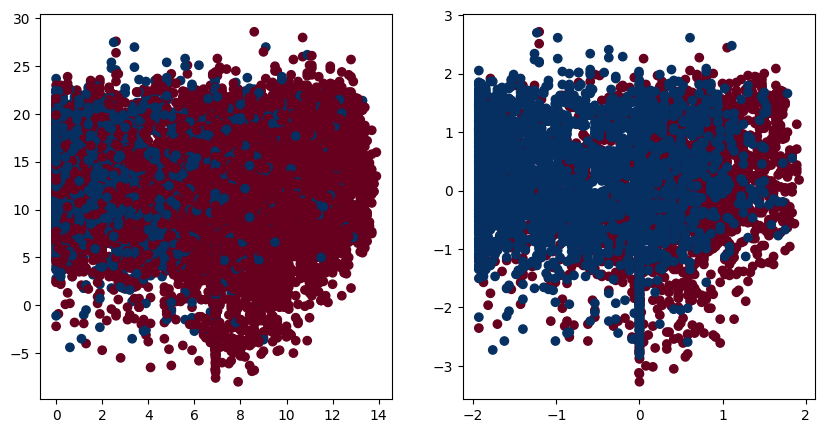

In [ ]:
### Hacemos dos gráficas, la de la izquierda tendrá los datos sin resamplear y la de la derecha los datos resampleados.
### Lo vamos a ver solo con dos features porque sino es imposible de graficar.

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(X_train_clf['Sunshine'], X_train_clf['MinTemp'], c=y_clf_train, cmap=plt.cm.RdBu)
ax[1].scatter(X_resampled_clf2['Sunshine'], X_resampled_clf2['MinTemp'], c=y_resampled_clf2, cmap=plt.cm.RdBu)
plt.show()

In [ ]:
reg_log.fit(X_resampled_clf2, y_resampled_clf2)
y_pred = reg_log.predict(X_test_clf_scaled)

cm_test_undersamp = confusion_matrix(y_clf_test, y_pred)

print("Resultados regresión logística con Oversampling:\n")
clf_report_under = classification_report(y_clf_test, y_pred)
print(clf_report_under)
print(confusion_matrix(y_clf_test, y_pred))

Resultados regresión logística con Oversampling:

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85      2309
         1.0       0.53      0.76      0.62       699

    accuracy                           0.79      3008
   macro avg       0.72      0.78      0.74      3008
weighted avg       0.83      0.79      0.80      3008

[[1831  478]
 [ 166  533]]


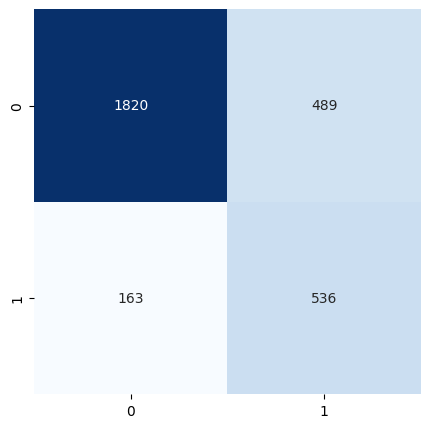

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(cm_test_oversamp, cbar=False, cmap='Blues', annot=True, fmt="d")
plt.show()

Aplicando RandomUnderSampler, la Precisión de clase 0 resulta muy similar que con el OverSampler.

De todos modos, decidimos quedarnos con el dataset resampleado con OverSampler.

### Comparación de Regresiones Logísticas

Modelo base:

In [ ]:
print(clf_report_base)

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87      2309
         1.0       0.00      0.00      0.00       699

    accuracy                           0.77      3008
   macro avg       0.38      0.50      0.43      3008
weighted avg       0.59      0.77      0.67      3008



Con Dataset original:






In [ ]:
print(clf_report_test)

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      2309
         1.0       0.70      0.50      0.58       699

    accuracy                           0.83      3008
   macro avg       0.78      0.72      0.74      3008
weighted avg       0.82      0.83      0.82      3008





Con OverSampler:



In [ ]:
print(clf_report_over)

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85      2309
         1.0       0.52      0.77      0.62       699

    accuracy                           0.78      3008
   macro avg       0.72      0.78      0.73      3008
weighted avg       0.83      0.78      0.80      3008





Con UnderSampler:

In [ ]:
print(clf_report_under)

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85      2309
         1.0       0.53      0.76      0.62       699

    accuracy                           0.79      3008
   macro avg       0.72      0.78      0.74      3008
weighted avg       0.83      0.79      0.80      3008



CONCLUSIÓN:

Todos los modelos superan en alguna medida al modelo base, lo cual nos brinda un buen punto de partida.

Los métodos de balance de clases del dataset mantienen buenas métricas para la clase 0 (No llueve), aunque disminuye bastante el Recall. Para la clase 1 (Llueve) se puede ver que en este caso el Recall aumentó, pero la Precisión disminuyó para esta clase.

Lo destacable del resampleo es que al aumentar la Precisión de la clase 0, tenemos más casos en los que se predice que no llueve realmente.
En cuanto al F1 se mantienen valores bastante parecidos en todos los casos.

### Validación cruzada

Realizamos KFolds y calculamos la precisión para la clase 0 para comparar con resultados anteriores.

In [ ]:
# Aplicamos 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Realizamos la validación cruzada obteniendo las predicciones para cada fold
y_pred_cv = cross_val_predict(reg_log, X_resampled_clf, y_resampled_clf, cv=kf)

# Calculamos la precisión para la clase 0
precision_class_0 = precision_score(y_resampled_clf, y_pred_cv, pos_label=0)

# Imprimimos el resultado
print('Precisión clase 0: {:.4f}'.format(precision_class_0))


Precisión clase 0: 0.7606


La precisión de la clase 0 luego de aplicar Validación Cruzada no resultó mejorar comparando a resultados anteriores.

Podemos concluir que la validación cruzada no dio resultados en la mejora del desempeño.

En el caso de este modelo, tampoco realizamos optimización de hiperparámetros ya que no aplicamos hiperparámetros en la instancia de creación del modelo.

###Explicabilidad SHAP

In [ ]:
feature_names = X_train_clf.columns

In [ ]:
# Creamos el objeto explainer SHAP
explainer = shap.Explainer(reg_log, X_resampled_clf, feature_names=feature_names)

In [ ]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_clf_scaled)

In [ ]:
explainer.expected_value

0.058652322890260344

####Interpretabilidad local

Observamos cómo se comporta un dato del conjunto de test.

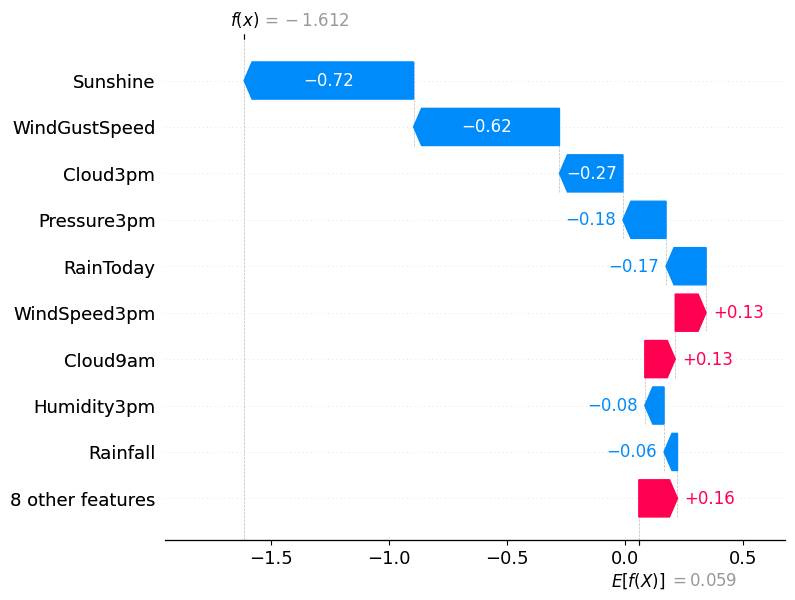

In [ ]:
# Gráfico cascada
index=0
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.waterfall(explanation)

En el gráfico de cascada, vemos cómo impacta cada variable explicativa en una predicción en particular.

Por ejemplo, notamos que 'Sunshine' es la variable que más está restando a las probabilidades de que llueva al día siguiente. Luego. 'WindGustSpeed' también resta, pero en menor medida.

Por otro lado, la variable 'WindSpeed3pm' y 'Cloud9am' son las que nos están sumando más a la hora de predecir, aunque en baja medida.


El valor base es igual a la media de los logaritmos de las chances y nos brinda una idea de probabilidad.

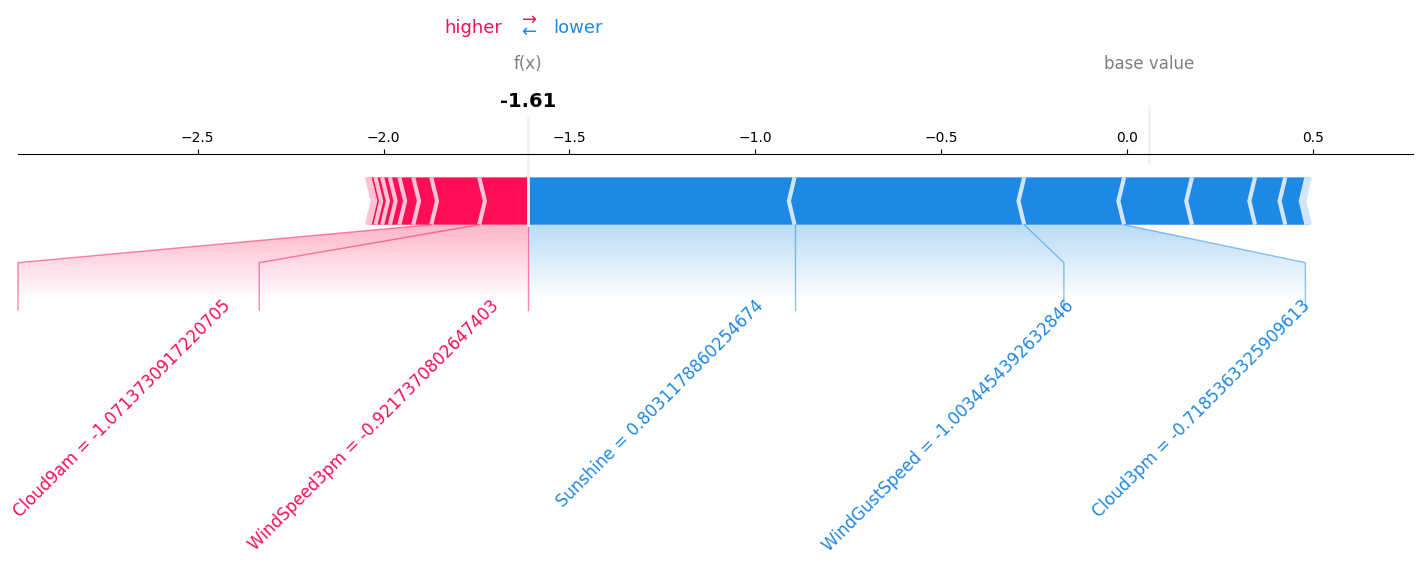

In [ ]:
# Gráfico de fuerza
index=0
shap.force_plot(explainer.expected_value, shap_values[index], X_test_clf_scaled[index], feature_names=feature_names, matplotlib=True, figsize=(18, 4), \
                text_rotation=45)

En el gráfico de fuerza se pueden ver las variables explicativas que más peso tienen y cuáles son aquellas que están sumando y restando para predecir si va a llover o no al día siguiente.


Se puede corroborar con el gráfico de cascada que la variable 'Sunshine' es la que más peso tiene y cómo esta restando a la hora de predecir, como también 'WindGustSpeed'. Aquella que más peso tiene a la hora de sumar se puede ver que es 'WindSpeed3pm'.



#### Interpretabilidad global

Vemos cómo impactan todas las variables explicativas sobre todo el conjunto de test.

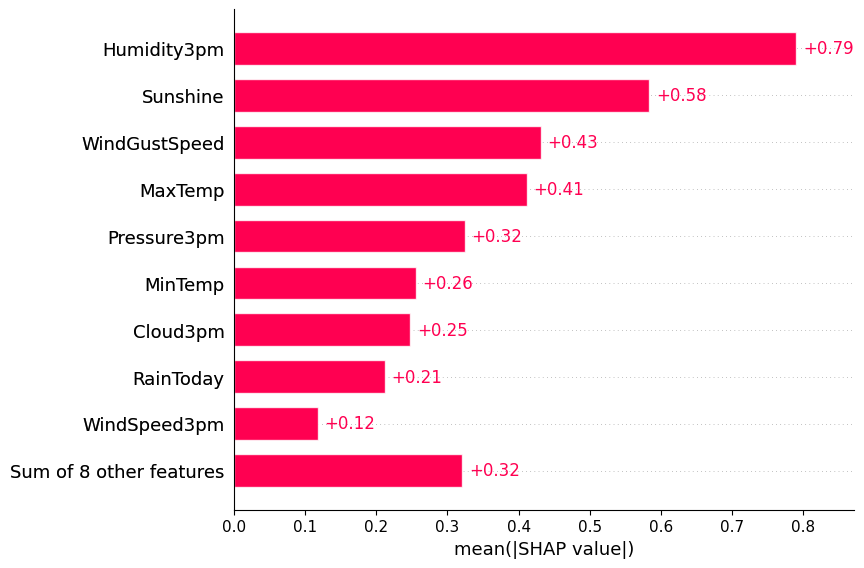

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_clf_scaled)
shap.plots.bar(explanation)

Podemos notar cómo impacta la salida en función de todas las variables explicativas, en promedio.

Vemos que 'Humidity3pm' es la variable más importante a la hora de explicar globalmente, en promedio, la predicción. Le sigue 'Sunshine' y luego 'WindGustSpeed'.

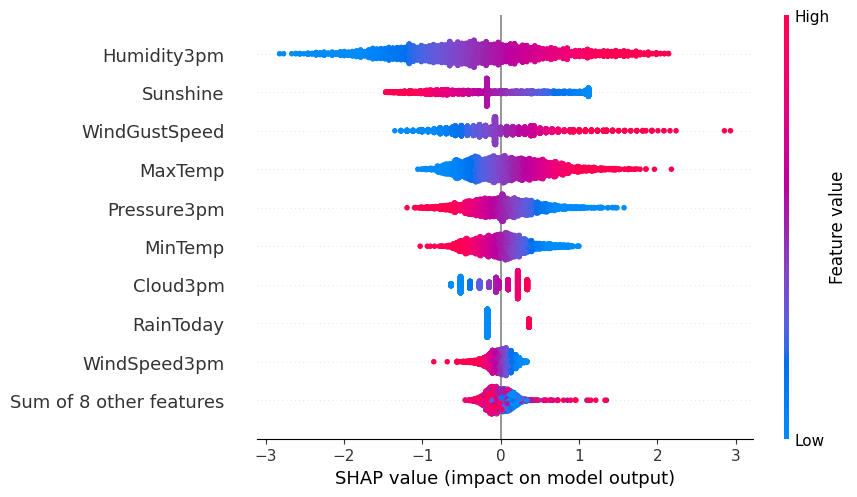

In [ ]:
# Gráfica enjambre de abejas
shap.plots.beeswarm(explanation)

Vemos el impacto que ocurre en la predicción para valores altos y bajos de las variables explicativas, y cómo están distribuidos los puntos para cada una.

Por ejemplo, se puede observar que, mientras más baja es 'Humidity3pm', menor probabilidad de que llueva se va a tener para el día siguiente, y mientras más alta es esta variable, mayor probabilidad de lluvia se tendrá. Para 'Sunshine' ocurre lo contrario, aunque podemos notar que tenemos mucha menor concentración de puntos para esta variable.

## Red neuronal

### Modelo I - Hiperparámetros seleccionados manualmente

### Hiperparámetros:

* 3 capas ocultas
* 10 neuronas por capa
* Función de activación: ReLu
* Función de activación de capa de salida: Sigmoid
* Épocas: 30
* Métrica: Precision(thresholds=0.7)
* Umbral de salida: 0.7

In [ ]:
# Connjuntos de validación
X_valid, X_test, y_valid, y_test = train_test_split(X_test_clf_scaled, y_clf_test,test_size=0.5,random_state = 12)

In [ ]:
model_nn_clf = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

In [ ]:
model_nn_clf.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(thresholds=0.7)])

In [ ]:
# Para entrenar el modelo de red neuroanl utilizamos nuestro dataset resampleado
historial_entrenamiento = model_nn_clf.fit(X_resampled_clf, y_resampled_clf, batch_size=32, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
581/581 [==============================] - 4s 4ms/step - loss: 0.5386 - precision_3: 0.8514 - val_loss: 0.4784 - val_precision_3: 0.6125
Epoch 2/30
581/581 [==============================] - 3s 4ms/step - loss: 0.4816 - precision_3: 0.8606 - val_loss: 0.4878 - val_precision_3: 0.6309
Epoch 3/30
581/581 [==============================] - 3s 5ms/step - loss: 0.4730 - precision_3: 0.8628 - val_loss: 0.4777 - val_precision_3: 0.6289
Epoch 4/30
581/581 [==============================] - 2s 4ms/step - loss: 0.4666 - precision_3: 0.8641 - val_loss: 0.4650 - val_precision_3: 0.6578
Epoch 5/30
581/581 [==============================] - 2s 4ms/step - loss: 0.4623 - precision_3: 0.8689 - val_loss: 0.4600 - val_precision_3: 0.6469
Epoch 6/30
581/581 [==============================] - 2s 4ms/step - loss: 0.4593 - precision_3: 0.8709 - val_loss: 0.4674 - val_precision_3: 0.6289
Epoch 7/30
581/581 [==============================] - 3s 5ms/step - loss: 0.4569 - precision_3: 0.8707 - val_los

In [ ]:
model_nn_clf.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 10)                180       
                                                                 
 dense_19 (Dense)            (None, 10)                110       
                                                                 
 dense_20 (Dense)            (None, 10)                110       
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 411 (1.61 KB)
Trainable params: 411 (1.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Métricas de validación
loss, precision = model_nn_clf.evaluate(X_valid, y_valid)
print(f'Pérdida test: {loss}')
print(f'Precisión test: {precision}')

47/47 [==============================] - 0s 2ms/step - loss: 0.4482 - precision_3: 0.6783
Pérdida test: 0.44819459319114685
Precisión test: 0.6783216595649719


In [ ]:
# Predicciones test
y_pred_clf_nn = model_nn_clf.predict(X_test)

# Predicciones train
y_pred_clf_train_nn = model_nn_clf.predict(X_train_clf_scaled)

376/376 [==============================] - 1s 2ms/step


#### Métricas del modelo con el conjunto de test y train

In [ ]:
y_pred_th_test = y_pred_clf_nn.copy()
for i, y in enumerate(y_pred_th_test):
  if y > 0.7:
    y_pred_th_test[i]=1
  else:
    y_pred_th_test[i]=0

In [ ]:
# Métricas test
cm_valid_nn = confusion_matrix(y_pred_th_test, y_test)

print("Resultados red neuronal con TensorFlow:\n")
print(classification_report(y_pred_th_test, y_test))
print(confusion_matrix(y_pred_th_test, y_test))

Resultados red neuronal con TensorFlow:

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89      1178
         1.0       0.59      0.65      0.62       326

    accuracy                           0.83      1504
   macro avg       0.74      0.76      0.75      1504
weighted avg       0.83      0.83      0.83      1504

[[1031  147]
 [ 115  211]]


In [ ]:
y_pred_th_train = y_pred_clf_train_nn.copy()
for i, y in enumerate(y_pred_th_train):
  if y > 0.7:
    y_pred_th_train[i]=1
  else:
    y_pred_th_train[i]=0

In [ ]:
# Métricas train
cm_valid_nn = confusion_matrix(y_pred_th_train, y_clf_train)

print("Resultados red neuronal con TensorFlow para conjunto de train:\n")
print(classification_report(y_pred_th_train, y_clf_train))
print(confusion_matrix(y_pred_th_train, y_clf_train))

Resultados red neuronal con TensorFlow para conjunto de train:

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90      9678
         1.0       0.60      0.69      0.64      2350

    accuracy                           0.85     12028
   macro avg       0.76      0.79      0.77     12028
weighted avg       0.86      0.85      0.85     12028

[[8567 1111]
 [ 717 1633]]


Gráfica Pérdida vs Epochs para optimizar nº de epochs

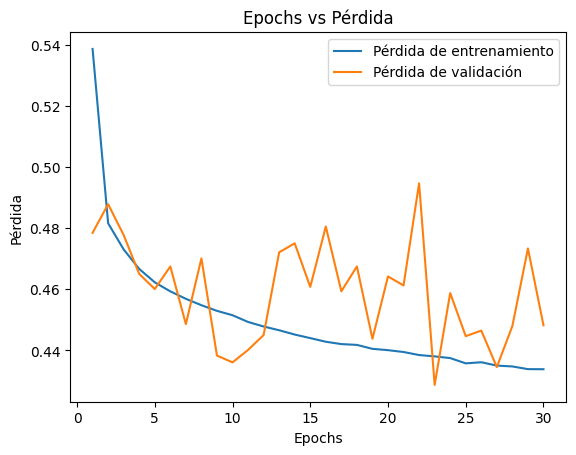

In [ ]:
# Extraemos la pérdida de entrenamiento y la pérdida de validación del historial
pérdida_entrenamiento = historial_entrenamiento.history['loss']
pérdida_validación = historial_entrenamiento.history['val_loss']

# Creamos la gráfica de las epochs versus la pérdida
epochs = range(1, len(pérdida_entrenamiento) + 1)
plt.plot(epochs, pérdida_entrenamiento, label='Pérdida de entrenamiento')
plt.plot(epochs, pérdida_validación, label='Pérdida de validación')
plt.title('Epochs vs Pérdida')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Comparando resultados de métricas para el modelo de Red Neuronal:

Precisión clase 0 test: 0.89

Precisión clase 0 train: 0.91

Son resultados muy comparables, por lo tanto concluimos que no estamos en presencia de overfitting.

### Optimización de hiperparámetros

In [ ]:
def objective_class(trial):

    num_layers = trial.suggest_int('num_layers', 1, 5)
    model = Sequential()

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128) # cantidad de neuronas de cada capa
        # activations = trial.suggest_categorical(f'')
        model.add(Dense(num_units, activation='relu')) # capas densas con activación ReLU

    # capa de salida
    model.add(Dense(1, activation='sigmoid')) # 1 clase de salida

    # compilar
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(thresholds=0.7)])

    # entrenar
    model.fit(X_train_scaled, y_train, validation_data=(X_valid_reg, y_valid_reg), epochs=30, batch_size=32, verbose=0)

    # evaluar
    loss, r2 = model.evaluate(X_test_reg, y_test_reg, verbose=0)
    return r2

# crear un estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores parámetros encontrados:", best_params)

[I 2023-12-06 22:54:03,767] A new study created in memory with name: no-name-cd5a1224-6798-49ec-8782-96f0b6f96f3c
[I 2023-12-06 22:55:26,641] Trial 0 finished with value: 0.3130376935005188 and parameters: {'num_layers': 3, 'n_units_layer_0': 120, 'n_units_layer_1': 99, 'n_units_layer_2': 7}. Best is trial 0 with value: 0.3130376935005188.
[I 2023-12-06 22:56:49,546] Trial 1 finished with value: 0.21857279539108276 and parameters: {'num_layers': 4, 'n_units_layer_0': 99, 'n_units_layer_1': 102, 'n_units_layer_2': 36, 'n_units_layer_3': 88}. Best is trial 0 with value: 0.3130376935005188.
[I 2023-12-06 22:57:28,629] Trial 2 finished with value: 0.34146440029144287 and parameters: {'num_layers': 2, 'n_units_layer_0': 5, 'n_units_layer_1': 100}. Best is trial 2 with value: 0.34146440029144287.
[I 2023-12-06 22:58:14,807] Trial 3 finished with value: 0.23761624097824097 and parameters: {'num_layers': 4, 'n_units_layer_0': 37, 'n_units_layer_1': 72, 'n_units_layer_2': 77, 'n_units_layer_3':

Mejores parámetros encontrados: {'num_layers': 2, 'n_units_layer_0': 75, 'n_units_layer_1': 47}


15 iteraciones (14 min):

Mejores parámetros encontrados: {'num_layers': 2, 'n_units_layer_0': 75, 'n_units_layer_1': 47}

A partir de la utilización de Optuna, obtuvimos los mejores hiperparámetros para el modelo.

Estos fueron:
* 2 capas
* Capa 0: 75 neuronas
* Capa 1: 47 neuronas


### Modelo II - Hiperparámetros optimizados

In [ ]:
model_nn_clf_opt = tf.keras.Sequential([
    tf.keras.layers.Dense(74, activation='relu'),
    tf.keras.layers.Dense(47, activation='relu'),
    #tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

In [ ]:
model_nn_clf_opt.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(thresholds=0.7)])

In [ ]:
# Para entrenar el modelo de red neuroanl utilizamos nuestro dataset resampleado
historial_entrenamiento = model_nn_reg_opt.fit(X_train_scaled, y_train, batch_size=32, epochs=30, validation_data=(X_valid_reg, y_valid_reg))
model_nn_clf_opt.fit(X_resampled_clf, y_resampled_clf, batch_size=32, epochs=30)

Epoch 1/30
400/400 [==============================] - 1s 4ms/step - loss: 32.3442 - r2_score: 0.3922 - val_loss: 35.3591 - val_r2_score: 0.3656
Epoch 2/30
400/400 [==============================] - 1s 3ms/step - loss: 32.1137 - r2_score: 0.3966 - val_loss: 35.3395 - val_r2_score: 0.3659
Epoch 3/30
400/400 [==============================] - 1s 3ms/step - loss: 31.9822 - r2_score: 0.3990 - val_loss: 35.8454 - val_r2_score: 0.3569
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 31.9056 - r2_score: 0.4005 - val_loss: 35.0301 - val_r2_score: 0.3715
Epoch 5/30
400/400 [==============================] - 2s 5ms/step - loss: 31.6437 - r2_score: 0.4054 - val_loss: 34.6825 - val_r2_score: 0.3777
Epoch 6/30
400/400 [==============================] - 2s 5ms/step - loss: 31.4519 - r2_score: 0.4090 - val_loss: 35.1832 - val_r2_score: 0.3687
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 31.4226 - r2_score: 0.4095 - val_loss: 34.8659 - val_r2_score:

In [ ]:
model_nn_clf_opt.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 74)                1332      
                                                                 
 dense_23 (Dense)            (None, 47)                3525      
                                                                 
 dense_24 (Dense)            (None, 1)                 48        
                                                                 
Total params: 4905 (19.16 KB)
Trainable params: 4905 (19.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Métricas de validación
loss, precision = model_nn_clf_opt.evaluate(X_valid, y_valid)
print(f'Pérdida test: {loss}')
print(f'Precisión test: {precision}')

47/47 [==============================] - 0s 3ms/step - loss: 0.4854 - precision_4: 0.6294
Pérdida test: 0.485394686460495
Precisión test: 0.6293929815292358


In [ ]:
# Predicciones test
y_pred_clf_nn = model_nn_clf_opt.predict(X_test_clf_scaled)

# Predicciones train
y_pred_clf_train_nn = model_nn_clf_opt.predict(X_train_clf_scaled)

376/376 [==============================] - 1s 2ms/step


#### Métricas del modelo con el conjunto de test y train

In [ ]:
y_pred_th_test = y_pred_clf_nn.copy()
for i, y in enumerate(y_pred_th_test):
  if y > 0.7:
    y_pred_th_test[i]=1
  else:
    y_pred_th_test[i]=0

In [ ]:
# Métricas test
cm_valid_nn = confusion_matrix(y_pred_th_test, y_clf_test)

print("Resultados red neuronal con TensorFlow:\n")
print(classification_report(y_pred_th_test, y_clf_test))
print(confusion_matrix(y_pred_th_test, y_clf_test))

Resultados red neuronal con TensorFlow:

              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89      2340
         1.0       0.61      0.63      0.62       668

    accuracy                           0.83      3008
   macro avg       0.75      0.76      0.75      3008
weighted avg       0.83      0.83      0.83      3008

[[2064  276]
 [ 245  423]]


In [ ]:
y_pred_th_train = y_pred_clf_train_nn.copy()
for i, y in enumerate(y_pred_th_train):
  if y > 0.7:
    y_pred_th_train[i]=1
  else:
    y_pred_th_train[i]=0

In [ ]:
# Métricas train
cm_valid_nn = confusion_matrix(y_pred_th_train, y_clf_train)

print("Resultados red neuronal con TensorFlow para conjunto de train:\n")
print(classification_report(y_pred_th_train, y_clf_train))
print(confusion_matrix(y_pred_th_train, y_clf_train))

Resultados red neuronal con TensorFlow para conjunto de train:

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      9465
         1.0       0.76      0.82      0.79      2563

    accuracy                           0.91     12028
   macro avg       0.86      0.87      0.86     12028
weighted avg       0.91      0.91      0.91     12028

[[8814  651]
 [ 470 2093]]


Gráfica Pérdida vs Epochs para optimizar nº de epochs

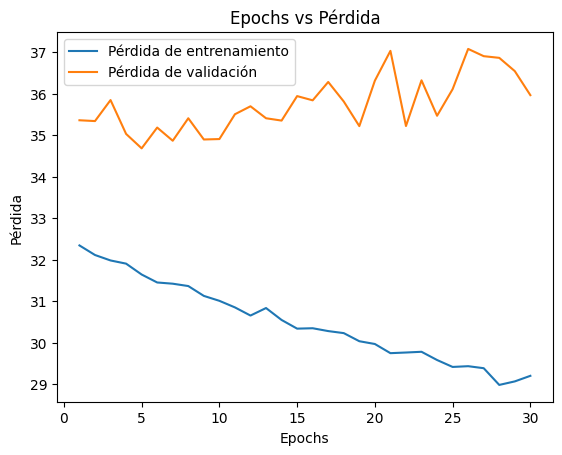

In [ ]:
# Extraemos la pérdida de entrenamiento y la pérdida de validación del historial
pérdida_entrenamiento = historial_entrenamiento.history['loss']
pérdida_validación = historial_entrenamiento.history['val_loss']

# Creamos la gráfica de las epochs versus la pérdida
epochs = range(1, len(pérdida_entrenamiento) + 1)
plt.plot(epochs, pérdida_entrenamiento, label='Pérdida de entrenamiento')
plt.plot(epochs, pérdida_validación, label='Pérdida de validación')
plt.title('Epochs vs Pérdida')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Comparando resultados de métricas para el modelo de Red Neuronal Optimizado:

Precisión clase 0 test: 0.90

Precisión clase 0 train: 0.95

Parecen indicar un leve overfitting.

###Explicabilidad SHAP

In [ ]:
# Creamos el objeto explainer SHAP
explainer = shap.Explainer(model_nn_clf_opt, X_train_scaled, feature_names=feature_names)

In [ ]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled)

PermutationExplainer explainer: 2257it [00:52, 36.13it/s]                          


####Interpretabilidad local

Observamos cómo se comporta un dato del conjunto de test.

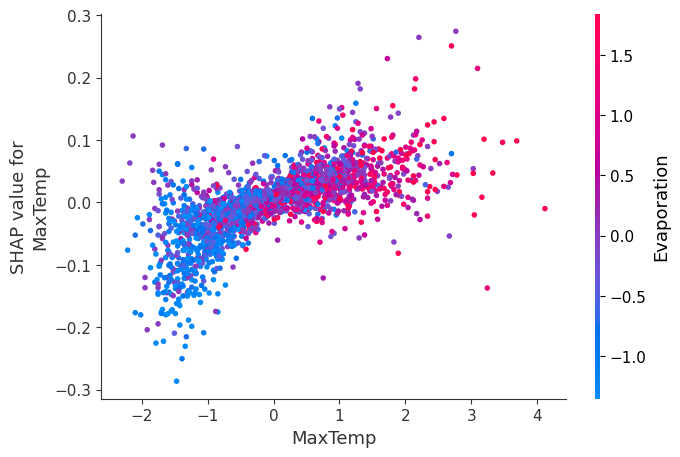

In [ ]:
# Gráfico de dependencias
shap.dependence_plot('MaxTemp', shap_values, X_test_scaled, feature_names=feature_names)

Se puede ver por ejemplo que tenemos una gran variación del valor SHAP para 'MaxTemp' cuando sus valores son bajos. Apoyandose en otra variable explicativa como 'Humidity9am', vemos que cuando la humedad es más baja, el rango de valores SHAP se achica por lo tanto se puede tener una mejor explicabilidad.

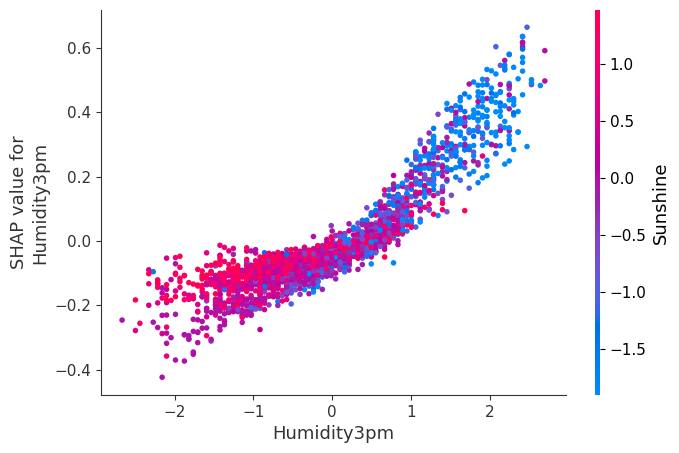

In [ ]:
shap.dependence_plot('Humidity3pm', shap_values, X_test_scaled, feature_names=feature_names)


En este caso, se puede ver que como contribuye la variable 'Sunshine' en el valor SHAP de 'Humidity3pm', ya que al disminuir su valor, se tienen un menor rango en valores SHAP y se puede explicar mejor el resultado de la observación para la variable explicativa 'Humidity3pm' cuando sus valores son bajos. Para valores altos de la humedad, se puede notar que el valor de 'Sunshine' siempre es bajo.



#### Interpretabilidad global

Vemos cómo impactan todas las variables explicativas sobre todo el conjunto de test.

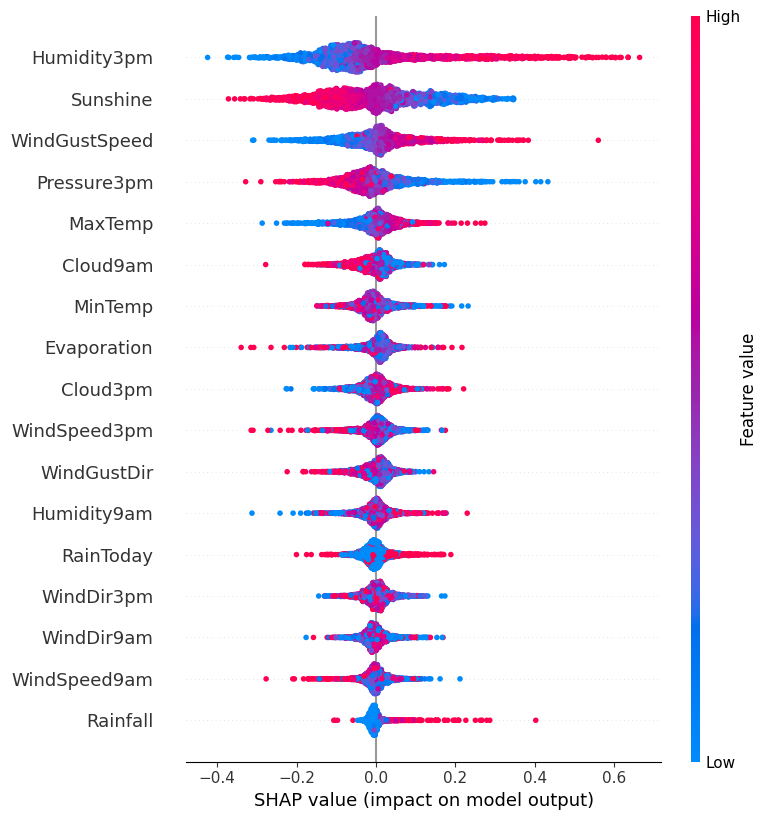

In [ ]:
# Gráfica enjambre de abejas
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

Vemos como impactan en la predicción las diferentes variables explicativas y sus distribuciones de datos. Por ejemplo para el caso de 'Humidity3pm' se puede observar que, para valores bajos de esta variable, la probabilidad de lluvia va a se más bajas y cuando su valor aumenta, las probabilidades serán mayores.


## Comparación de modelos de Clasificación

Decidimos tomar como referencia la métrica de Precisión para la clase 0 (RainTomorrow = No)

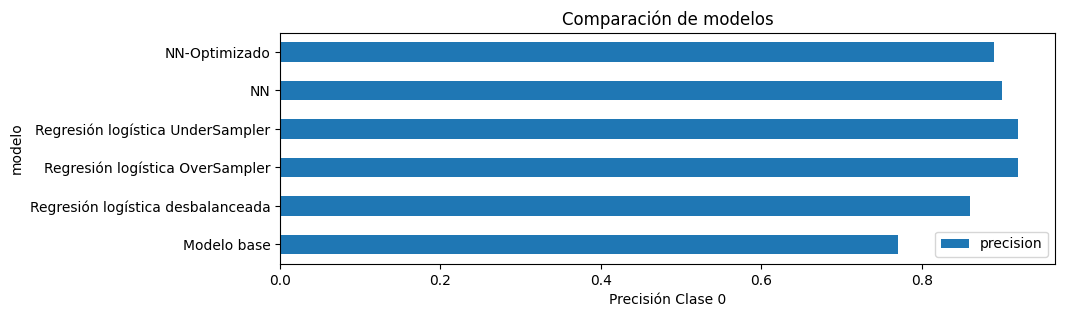

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['Modelo base', 'Regresión logística desbalanceada', 'Regresión logística OverSampler', 'Regresión logística UnderSampler', 'NN','NN-Optimizado'],
                    'precision': [0.77, 0.86, 0.92, 0.92, 0.90, 0.89]
                 })

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('Precisión Clase 0')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

En los modelos de clasificación observamos una mejor performance en general.
Todos los modelos aplicados superan el Modelo base.

Los mejores resultados los obtuvimos utilizando Regresión Logística entrenada con un conjunto de datos balanceado.

Los modelos de redes neuronales obtenidos no mejoraron esa performance, aunque la optimización no llegó a ser muy buena dado el tiempo de ejecución requerido (sólo se ejecutó con 15 iteraciones). Si fuese posible aumentar esa cantidad, existe la posibilidad de que alcancemos una red neuronal de mayor precisión.

De todas maneras, las métricas obtenidas en las Regresiones logísticas balanceadas son muy satisfactorias, además de que estos modelos implican un costo computacional menor al de las Redes Neuronales. Por lo tanto, estos fueron los elegidos en primer lugar para llevar a producción.

Sin embargo, la presición en la clase 1 es mayor en las Redes Neuronales y esto se manifiesta en las primeras pruebas en producción, obteniendo malos resultados con las Regresiones Logísticas para las predicciones de días de lluvia. Por esto último, el modelo seleccionado fue la Red Neuronal No Optimizada.

# MLOps

In [ ]:
pipeline_regresion = Pipeline([
    ('Regresion', model_nn_reg_opt),  # Modelo de predicción de RainfallTomorrow
])

joblib.dump(pipeline_regresion, 'RainfallTomorrowAUS.joblib')

['RainfallTomorrowAUS.joblib']

In [ ]:
pipeline_clasificacion = Pipeline([
    ('Clasificación', model_nn_clf),  # Modelo de predicción de RainTomorrow
])

joblib.dump(pipeline_clasificacion, 'RainTomorrowAUS.joblib')

['RainTomorrowAUS.joblib']

# Interfaz de usuario

La interfaz solicitará las siguientes características en los siguientes rangos:

MinTemp           [-10.0 ; 50.0] [°C]

MaxTemp           [-10.0 ; 50.0] [°C]

Rainfall	        [0.0 ; 400.0] [mm]

Evaporation		    [0.0 ; 200.0] [mm]

Sunshine		      [0.0 ; 24.0] [hs]

WindGustDir		    [1 ; 16]	(puntos cardinales)

WindGustSpeed			[0.0 ; 200.0] [km/h]

WindDir9am		    [1 ; 16]	(puntos cardinales)

WindDir3pm		    [1 ; 16]	(puntos cardinales)

WindSpeed9am      [0.0; 200.0] [km/h]

WindSpeed3pm      [0.0; 200.0] [km/h]

Humidity9am       [0.0 ; 100.0] [%]

Humidity3pm       [0.0 ; 100.0] [%]

Pressure3pm	      [870.0; 1080.0] [hpa]

Cloud9am          [0 ; 8]

Cloud3pm          [0 ; 8]

RainToday         [0 ; 1]



puntos_cardinales = {'N': 1,
                     'NE': 2,
                     'NW': 3,
                     'NNE': 4,
                     'NNW': 5,
                     'S': 6,
                     'SE': 7,
                     'SW': 8,
                     'SSE': 9,
                     'SSW': 10,
                     'W': 11,
                     'WNW': 12,
                     'WSW': 13,
                     'E': 14,
                     'ENE': 15,
                     'ESE': 16}

# Conclusiones

En este proyecto se realizaron diversos modelos para predecir, por un lado, si va a llover o no el día siguiente, y por otro, la cantidad de lluvia para el día siguiente, a partir de un set de datos con distintas características del clima de Australia.

En primer lugar se realizó la exploración y análisis de datos para poder limpiar el dataset e imputar los valores faltantes. A su vez se tuvieron que codificar algunas variables específicas que presentaban tipo de datos categóricos, como así también, escalar los datos para equilibrar las unidades.

* Para la predicción de cantidad de lluvia, realizamos varios modelos de Regresión, entre ellos Regresión Lineal, Gradiente Descendiente, Regularización y Red Neuronal, donde fuimos comparando entre cada uno la métrica correspondiente al r2 (coef. de determinación). El mejor resultado lo obtuvimos con el modelo de Red Neuronal, con un r2 cercano a 0.4.

* Para la predicción de lluvia, realizamos dos modelos de Clasificación: Regresión Logística y Red Neuronal. En este caso, optamos por comparar la Precisión de la clase 0 (no llueve), y obtuvimos el mejor resultado en la Regresión Logística, con un valor para esa métrica de 0.92.

Para el caso de Clasificación, tuvimos que realizar un balance del dataset ya que las clases presentaban un desbalance notorio. De este modo el resultado de la Regresión Logística con el set de datos balanceado mejoró en gran medida la métrica de Precisión para la clase que se venía estudiando.

Para todos los modelos aplicamos Explicabilidad SHAP, donde a partir de los gráficos, pudimos observar con más detenimiento el aporte y fuerza de cada variable explicativa en el modelo que se estaba estudiando.

Luego de numerosas pruebas con los modelos de predicción planteados pudimos apreciar ventajas y desventajas de cada uno en relación a la complejidad de implementación, costos de ejecución y resultados obtenidos. Al tratarse de modelos basados en estadísticas los resultados para un mismo conjunto de datos de predicción pueden diferir entre los modelos.

Consideramos que para alcanzar robustez y confiabilidad en los modelos que se aplicarán en producción es fundamental cumplir con estas características:
- Partir de datos que describan la mayor cantidad de condiciones posibles sobre el fenómeno a predecir. Para esto es muy útil contar con un dataset lo más completo y balanceado posible, analizando y seleccionando estratégicamente las features que se utilizarán en los modelos.

- En la etapa de desarrollo probar distintas técnicas y modelos, variando y optimizando los parámetros.

- Seleccionar correctamente las métricas que se utilizarán para la comparación de los resultados obtenidos, teniendo presente el contexto del objetivo final de la predicción de los modelos, para finalmente seleccionar el/los modelos finales para aplicar en producción.


